## Note: Please ensure you run this workbook from the same folder as where the underlying data files are stored in your computer.

# Preparing the Environment for Exploratory Data Analysis

In [1]:
# Imports of Models, Libraries & Date Parsing Functionality 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import nltk
import os
import string   
import re
import math
import squarify
import plotly.express as px
import requests
import functools as ft

# Copy the YAML file and Twitter keys over to this Jupyter Notebook before you start to work.
import yaml
from yaml.loader import SafeLoader
from twitter import *
import tweepy

from pywaffle import Waffle
from datetime import datetime
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from textblob import TextBlob
from scipy.stats import norm
from collections import Counter

from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

# Setting up a date parser using a private funciton, lambda
# This will give us the dates in a format we require for aggregation & indexation
d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

# Default settings for matplotlibs to be used throughout
plt.rcParams["axes.facecolor"] = "w"

# Exploring Twitter Data about Cycling

Is it at all worthwhile to look at cycling in London? Asides the traditional data that has bee supplied, the task here is to extract the most recent posts on Twitter about Cycling. From these, the objectives are:
- Discover locational information around where the topic generates the most social media content from 
- To see if any of the three cities being analysed are amongst these locations
- Get an overview of the sentiment expressed in such content on the topic
- Get an overview of the most common words used in such content to discover any underlying themes that can be explored further.

The output of this analysis using social data can be used as supplementary evidence to partially inform the hypothesis that Londoner's can be influenced to increase the uptake of cycling amongst them. 

In [2]:
# Copy the YAML file and Twitter keys over to this Jupyter Notebook before you start to work.
# Import the yaml file - remember to specify the whole path and use / between directories
twitter_creds = yaml.safe_load(open('twitter_tmp.yaml', 'r').read())

# To investigate the Tweets & Sentiment Analysis

nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Pass Tweepy credentials
tweepy_api = Twitter(auth=OAuth(twitter_creds['access_token'],
                                 twitter_creds['access_token_secret'], 
                                 twitter_creds['api_key'],
                                 twitter_creds['api_secret_key'] ))

In [4]:
# Pass your Twitter credentials.
twitter_api = Twitter(auth=OAuth(twitter_creds['access_token'],
                                 twitter_creds['access_token_secret'], 
                                 twitter_creds['api_key'],
                                 twitter_creds['api_secret_key'] ))

In [5]:
# Check Tweepy connection
print(tweepy_api)

In [6]:
# Check Twitter connection
print(twitter_api)

## Building up the dataset

In [7]:
# Look for the term cycling on Twitter
# Ordered by recency
# Filtering for Tweets only in English
# Note that the free Twitter API being used here only allows access to the seven most recent days of tweets
# Looks for the most recent 4,000 tweets on cycling each time this is run

q = {'q':'cycling', 'lang':'en', 'count':100, 'result_type':'recent'}

# Results as an empty list.
results = []

while len(results) < 40:
    query = twitter_api.search.tweets(**q)
    q['max_id'] = query['search_metadata']['next_results'].split('&')[0].split('?max_id=')[1]
    results.append(query)
    
# Determine the number of results.
len(results)

# Repeat this process over several days to get a meaningfully large dataset
# continue this once a day for as long as possible

40

In [8]:
# Flatten the results in a DataFrame for NLP Analysis
df2 = pd.concat([pd.DataFrame(_['statuses']) for _ in results])

In [9]:
# Store the data as a backup & in order to build up the data set
# Recall each scrape only gathers max 4000 tweets
# So, to build a large dataset have to scrape over several days
df2.to_csv('twitter_scrape_saurav_151022enb.csv')

In [11]:
# Build up the data source from the daily extracts
df2 = pd.read_csv('twitter_scrape_saurav_071022en.csv')
df3 = pd.read_csv('twitter_scrape_saurav_081022en.csv')
df4 = pd.read_csv('twitter_scrape_saurav_091022en.csv')
df5 = pd.read_csv('twitter_scrape_saurav_101022en.csv')
df6 = pd.read_csv('twitter_scrape_saurav_111022en.csv')
df7 = pd.read_csv('twitter_scrape_saurav_111022ena.csv')
df8 = pd.read_csv('twitter_scrape_saurav_121022en.csv')
df9 = pd.read_csv('twitter_scrape_saurav_131022en.csv')
df10 = pd.read_csv('twitter_scrape_saurav_131022ena.csv')
df11 = pd.read_csv('twitter_scrape_saurav_131022enb.csv')
df12 = pd.read_csv('twitter_scrape_saurav_131022enc.csv')
df13 = pd.read_csv('twitter_scrape_saurav_141022en.csv')
df14 = pd.read_csv('twitter_scrape_saurav_151022en.csv')
df15 = pd.read_csv('twitter_scrape_saurav_151022enb.csv')

# Means we are scraping c. 55,000 which have been extracted over the past 7 days
# Provides a meaningfully large dataset for analysis

In [12]:
# Concatenate the datasets
# Creates a master dataset
Df = pd.concat([df2,df3,df4,df5, df6,df7,df8,df9,df10,df11,df12,df13, df14,df15])

In [13]:
# View random samples of the outputs
Df.sample(2)

,Unnamed: 0,created_at,id,id_str,text,truncated,entities,extended_entities,metadata,source,...,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,Unnamed: 0.1
874,87,Sun Oct 09 00:36:10 +0000 2022,1578907133923688448,1578907133923688448,RT @jamiemccue_: What do I want to see come ou...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",...,0,False,False,False,en,{'created_at': 'Sat Oct 08 15:23:06 +0000 2022...,NaN,NaN,NaN,NaN
1143,56,Sat Oct 08 23:21:33 +0000 2022,1578888359572738049,1578888359572738049,RT @_dmoser: 🚲🚲\n\nDo you know that cycling is...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1578140695776346117, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,0,False,False,True,en,{'created_at': 'Sat Oct 08 15:50:00 +0000 2022...,NaN,NaN,NaN,NaN


In [14]:
# Check Metadata
Df.info()

# 55,450 tweets so far

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55450 entries, 0 to 3902
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 55450 non-null  int64  
 1   created_at                 55450 non-null  object 
 2   id                         55450 non-null  int64  
 3   id_str                     55450 non-null  int64  
 4   text                       55450 non-null  object 
 5   truncated                  55450 non-null  bool   
 6   entities                   55450 non-null  object 
 7   extended_entities          4370 non-null   object 
 8   metadata                   55450 non-null  object 
 9   source                     55450 non-null  object 
 10  in_reply_to_status_id      13465 non-null  float64
 11  in_reply_to_status_id_str  13465 non-null  float64
 12  in_reply_to_user_id        13756 non-null  float64
 13  in_reply_to_user_id_str    13756 non-null  floa

In [15]:
# Parse the created_at column into pd datetime formate
Df['created_at'] = pd.to_datetime(Df.created_at)

In [16]:
# Search for duplicates & retain just the most recent tweet
# Look for duplicates and drop them based on created at and user

df = Df.drop_duplicates(subset = ['created_at', 'user', 'id'],
  keep = 'last').reset_index(drop = True)

# This avoids duplication of tweets created by the same user, at the same time & same id
# Duplicates may be extracted as part of the scrape
# This process removes such duplicates, if any.

In [17]:
# Check Metadata
df.info()

# Not much geo data captured. 
# User has geo data within it after keyword 'location' per Twitter API documentation
# 49,436 unique tweets extracted on cycling so far.
# Need to keep running this process every day to build up a meaningfully large database

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49436 entries, 0 to 49435
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   Unnamed: 0                 49436 non-null  int64              
 1   created_at                 49436 non-null  datetime64[ns, UTC]
 2   id                         49436 non-null  int64              
 3   id_str                     49436 non-null  int64              
 4   text                       49436 non-null  object             
 5   truncated                  49436 non-null  bool               
 6   entities                   49436 non-null  object             
 7   extended_entities          3967 non-null   object             
 8   metadata                   49436 non-null  object             
 9   source                     49436 non-null  object             
 10  in_reply_to_status_id      11947 non-null  float64            
 11  in

In [18]:
# Extract user details into a seperate Df for later analysis
# Twitter Api docs indicate this field may contain location data
df1 = df['user'].values

In [19]:
# View one raw result
df1[2]

# Confirms user has many variables incl geo data

"{'id': 1336486512175673344, 'id_str': '1336486512175673344', 'name': 'Bounce Deals', 'screen_name': 'BounceDeals_', 'location': '', 'description': 'Supplying YOU the latest Amazon Deals & Discounts — Start saving TODAY! \\nTweets contain affiliate links 🔗\\n\\nLooking for more deals? Check out @bouncesoftware', 'url': 'https://t.co/61dBuIvPRM', 'entities': {'url': {'urls': [{'url': 'https://t.co/61dBuIvPRM', 'expanded_url': 'http://bouncealerts.com', 'display_url': 'bouncealerts.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 154, 'friends_count': 1, 'listed_count': 1, 'created_at': 'Wed Dec 09 01:43:59 +0000 2020', 'favourites_count': 3, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 9672, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'F5F8FA', 'profile_background_image_url': None, 'profile_background_

In [20]:
# Confirm how the data under user is presently stored
print(type(df1))

<class 'numpy.ndarray'>


In [21]:
# Check dimension of numpy array
np.shape(df1)
# No columns.

(49436,)

In [22]:
# Convert to pandas dataframe
user = pd.DataFrame(df1)

In [23]:
# Double check output
user.info()
# 1 Column with 49,436 rows of data 
# Need to transform this where rows become columns
# user id is stripped of its underlying metadata
# As this is still a small enough file, will do this in Excel

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49436 entries, 0 to 49435
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       49436 non-null  object
dtypes: object(1)
memory usage: 386.3+ KB


In [24]:
# Covert to Excel file & create columns there and reimport
user.to_csv('user.csv')

# cleaned up shape somewhat in Excel to isolate some of the information 
# This is a task being done in Excel to keep the workbook here as compact as possible
# reload this cleaned up data later when doing analysis on location

In [25]:
# Determine the text of the actual tweet
df2 = df['text'].values

In [26]:
# View one raw result
# Confirms that the body of the post is stored here
df2[1]

'RT @Nat_Games_Guj: Honourable Minister of Sports Shri @sanghaviharsh Ji  flags off a 120km men’s cycling race at Gandhinagar, CHH \n\n#Nation…'

## Prepare the data for NLP & Sentiment Analysis

In [27]:
# Introduce Stopwords
stop_words = set(stopwords.words('english'))

In [28]:
# Split up each tweet into individual words.
df2_token = [word_tokenize(_) for _ in df2]

# Not viewing all output to reduce size of workbook
# Just viewing one output instead
df2_token[5]

['RT',
 '@',
 'GalwayCycling',
 ':',
 '@',
 'GalwayCityCo',
 'Hey',
 'Council',
 ',',
 'here',
 '’',
 's',
 'actions',
 '*',
 'you',
 '*',
 'can',
 'do',
 'to',
 'keep',
 'children',
 'safe',
 'going',
 'to',
 'school',
 ':',
 '-',
 '30km/h',
 'speed',
 'limits',
 '-',
 'Wi…']

In [29]:
# Get a list of all English words so we can exclude anything that doesn't appear on the list.
all_english_words = set(words.words())

In [30]:
# Some pre-processing:
# Get every word.
# Convert it to lowercase.
# Only include if the word is alphanumeric and if it is in the list of English words.

df2_token_nostop =\
[[y.lower() for y in x if y.lower() not in stop_words and y.isalpha() and y.lower() in all_english_words]\
 for x in df2_token]

In [31]:
# View output
df2_token_nostop[5]

['hey', 'council', 'keep', 'safe', 'going', 'school', 'speed']

In [32]:
# Create a variable to store the Sentiment Intensity Analyser
darth_vader = SentimentIntensityAnalyzer()

In [33]:
# Run through a dictionary comprehension to take every cleaned tweet. 
# Next run the polarity score function on the string.
# This will return four values in a dictionary.

df2_polarity =\
{" ".join(_) : darth_vader.polarity_scores(" ".join(_)) for _ in df2_token_nostop}

In [34]:
# Convert the list of dictionary results to a pandas dataframe. 
# The index is the cleaned tweet.

polarity_pd = pd.DataFrame(df2_polarity).T

# View the Dataframe
polarity_pd

# Compound score indicates actual sentiment

,neg,neu,pos,compound
deal found gear beast running men lightweight running vest phone holder,0.000,1.000,0.000,0.0000
minister sports men cycling race,0.000,1.000,0.000,0.0000
win gift card giveaway enter,0.000,0.309,0.691,0.7717
never easier get faster flag cycling competition,0.280,0.720,0.000,-0.3252
hey council keep safe going school speed,0.000,0.674,0.326,0.4404
...,...,...,...,...
worn van giro time trial entire,0.306,0.694,0.000,-0.2960
ever running assessment endurance marathon health running,0.000,1.000,0.000,0.0000
government cycling infrastructure roll,0.000,1.000,0.000,0.0000
running cycling difference maker,0.000,1.000,0.000,0.0000


### Visualising the data with Charts

Sentiment

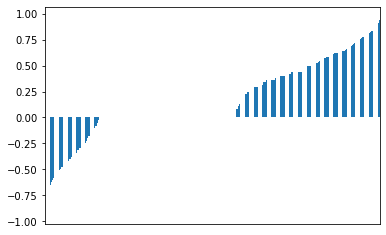

In [35]:
# Visualise the output in a distribution
%matplotlib inline
import matplotlib.pyplot as plt

_plot = polarity_pd.reset_index()['compound'].sort_values()
ax1 = plt.axes()
_plot.plot(kind='bar')

x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

plt.show()
plt.close()

- Most values are 0 (neutral) - blank spaces
- More positive sentiment than negative sentiment amongst non-neutral values
- Some very strong positive sentiment > 0.75
- Some very strong negative sentiment also visible < -0.75

A histogram plot will visualise the distribution of sentiment better although the strictly neutral values should be removed which will help make the histogram clearer.

In [36]:
# Remove polarity values equal to zero 
# This will improve the scale of the histogram and remove all strictly neutral reviews from the analysis
# This will better highlight the distribution of polarity values = sentiment
# Define the source of the data to use for plotting histogram
data = polarity_pd['compound'][polarity_pd['compound'] != 0]

Text(0.5, 1.0, 'Non Neutral Sentiments from most recent Tweets on Cycling')

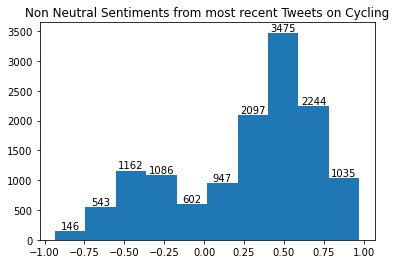

In [37]:
# Visualise the distribution of the sentiment analysis using histogram
count, edges, bars = plt.hist(data)
plt.bar_label(bars)
plt.title('Non Neutral Sentiments from most recent Tweets on Cycling')


# The exact numbers will change each time this notebook is rerun as the data will be changed
# Refresh the analytical content as this changes

# Many more strongly positive sentiment (>0.75 polarity score) = 1035 tweets
# Far fewer strongly negative sentiment (<-0.75 polarity score) = 146 tweets
# Overall, sentiment when non neutral is strongly skewed in favour of cycling
# Indicates that on the whole from this small sample size, sentiment towards cycling is positive
# However, recall there are c.49,500 unique tweets.
# Only c.27% of tweets display non 0 sentiment
# Means vast majority feel very neutral about cycling based on this data
# Indicates that there is room to improve sentiment towards cycling
# This can only come from increased cycling uptake and campaign to increase cycling uptake.
# Worthwhile therefore to pursue increasing uptake of cycling
# Scope to increase cycling uptake established using sentiment analysis given
# Scope to increase non neutral sentiment on cycling
# General non neutral sentiment is positive so people should have no objection to at least trying out cycling

Top Words Visualised in a WordCloud

In [38]:
# Ensure all words are stored in a list which can then be used to create a WordClod
print(type(df2_token_nostop))

# Confirmed words are in a list

<class 'list'>


In [40]:
# Reformat list into string for use to generate wordcloud
s = ''.join(str(x) for x in df2_token_nostop)

In [57]:
# Check the most common items in the list 
# Will identify the obvious words which can be removed from the list before WordCloud is generated
# This will enhance the accuracy of the WordCloud
from collections import Counter
# split() returns list of all the words in the string
split_y = s.split()
  
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_y)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(10)
  
print(most_occur)

# From these identify the most common words which fail to convey any meaning or sentiment

[("'cycling',", 17201), ("'get',", 2891), ("'track',", 2478), ("'bike',", 2391), ("'use',", 2193), ("'time',", 2150), ("'sustainable',", 2058), ("'spend',", 1595), ("'like',", 1588), ("'always',", 1574)]


In [58]:
# Remove cycling and other obv words from the list 
# Else they will skew the results
# Define these words as bespoke stopwords
stop_words = ['cycling', 'cycling ', 'distance', 'distance ', 'cyclingcycling', 'transport', 'found', 
              'evidence', 'transport ', 'bike ', 'helmet', 'cycle ', 'transport ', 
              'public', 'society', 'source', 'hour', 'get']

In [59]:
# Creating new list to avoid messing up orginal list
new_s = [word for word in s if word not in stop_words]

In [60]:
# Reformating into string again for wordcloud generation
st = ''.join(str(x) for x in new_s)

In [61]:
# Strip all punctuation
new_string = st.translate(str.maketrans('', '', string.punctuation))

In [62]:
# Generate Word Cloud using the 20 frequently used words when tweeting about cycling
wordcloud = (WordCloud(max_font_size=50, max_words=20, 
                       background_color="grey").generate(new_string))

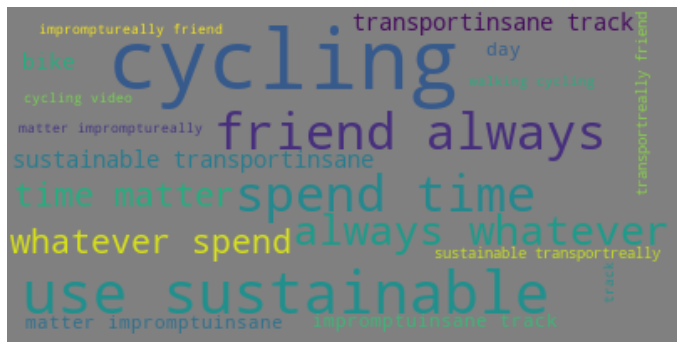

In [63]:
# Review: Display the WordCloud.
wordcloud.generate(new_string)
plt.figure(figsize=(12, 10))
plt.axis('off') 
plt.imshow(wordcloud, interpolation="bilinear")

# Displays the top 20 most commonly used words by Twitter users when they post about Cycling
# Relative Size displays frequency of the words
# There are words which suggest an ongoing debate about the potential merit of cycling
# Words such time, matter, whatever, spend and insane occur within the top 20 words
# These together, suggest evidence of a public who are still debating the merits of cycling
# Reinforces the case for the trying to influence cycling uptake as any debate can within reason be influenced
# With mix of policy and strategic marketing

## Insights from Geo Data

Objective is to see the location of Twitter users posting about cycling. The top most amongst these are the places of most interest to use for comparative analysis against London. 

Further, if London is in the list of places from where people most frequently tweet on cycling, it would show that Londoners are generally animated on the topic and it is worthwhile to try to influence their uptake on cycling.

In [48]:
# Open reshaped user data
# Unshaped data was in user.csv
# After shaping its been saved as userA.csv
user = pd.read_csv('userA.csv')

In [49]:
# check metadata
user.info()

# There are 49,436 unique users on whom there is data
# Aligns to earlier meta data
# Confirms integrity of the data wrangling in Excel

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49436 entries, 0 to 49435
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Column1      49436 non-null  int64 
 1   user_id      49436 non-null  object
 2   id_str       49436 non-null  object
 3   name         49436 non-null  object
 4   screen_name  49436 non-null  object
 5   location     49436 non-null  object
 6   location_2   49435 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.6+ MB


In [50]:
# See sample of the data
user.head(2)

# Confirms location & sometimes location_2 have geo data
# needs cleaning

,Column1,user_id,id_str,name,screen_name,location,location_2
0,0,{'id': 1346300596035452928,'id_str': '1346300596035452928','name': 'MR ONLINE DEALS','screen_name': 'MrOnlineDealz','location': '','description': 'Finding the BEST Amazon Deals
1,1,{'id': 1295065467548241921,'id_str': '1295065467548241921','name': 'kamaljeet Ramta','screen_name': 'bjpkamaljeet','location': 'Gandhinagar Gujrat','description': 'STATE EXECUTIVE MEMBER IT BJP...


In [51]:
# Remove all punctuation marks from location columns
user["location"] = user['location'].str.replace('[^\w\s]','')
user["location_2"] = user['location_2'].str.replace('[^\w\s]','')

# Remove all non-alphabet values & cast as string
user["location"] = user['location'].astype(str).replace('[^a-zA-Z0-9 ]', '', regex=True)
user["location_2"] = user['location_2'].astype(str).replace('[^a-zA-Z0-9 ]', '', regex=True)

In [52]:
# Remove the first two words from the column location
user['location'] = user['location'].str.split(n=1).str[1]

# Delete all except first word in location 2
# location 2 appears to sometimes contain additional location value in the first word
user['location_2'] =user['location_2'].drop_duplicates().str.split().str[0]

In [53]:
# Drop all rows with Null values in location
# As this is primary search objective, null value rows cannot be interpreted for analysis
# Removing them will produce cleaner output
user = user[user.location.notnull()]

In [54]:
# Fill all Null values in location_2 with Unknown
# This is secondary
user.location_2 = user.location_2.fillna('Unknown')

# Replace description with unknown in location_2
# replace at home with unknown in location
user = user.replace(['description','At home'],['Unknown', 'Unknown'])

In [55]:
# Rename columns & drop unwanted columns
user = user.rename(columns={'location': 'city', 'location_2': 'country'})
user = user.drop(['id_str', 'user_id', 'name', 'screen_name'], axis=1)

# Maintains a small Df which is memory efficient

In [56]:
# Count unique values in each column
for col in user:
  print(col,": ", user[col].nunique())

# 8914 unique cities (location)
# 1051 unqiue fields in country (location2)

Column1 :  33761
city :  8914
country :  1051


In [64]:
# Cleaning up the data to ensure mapping is more accurate
# Aggregating some of the more obvious locations to London incl home counties & general country descriptions
user['city'] = user['city'].replace(['UK','United Kingdom', 'England', 'NW London', 'N London', 'NE London',
                                    'W London', 'E London', 'S London', 'SE London', 'SW London', 'Berkshire',
                                    'Berks', 'Buckinghamshire', 'Bucks', 'Essex', 'Herts', 'Hertfordshire',
                                    'Kent', 'Surrey', 'Sussex', 'Brixton', 'SE5'],'London')

# Assumes all UK related locations are London unless specified otherwise

In [65]:
# Aggregate the city & country counts
# This will produce
locs = user['city'].value_counts()
locs_2 = user['country'].value_counts()

In [69]:
# View output from country values
locs.head(20)

London           2726
Earth             683
California        448
Ottawa            433
Cambridge         347
Toronto           336
United States     207
Scotland          206
Langley           193
Manchester        187
Ireland           187
Vancouver         186
Edinburgh         184
India             168
New York          157
Glasgow           157
Lagos             154
USA               153
Wheeling          150
Melbourne         149
Name: city, dtype: int64

In [70]:
# View output from country values
locs_2.head(20)

# Less useful as top 3 are clearly unidentifiable locations
# Before joining this data set with other location data, remove the clearly unidentifiable elements
# Then join the two series to aggregate the counts of the locations

UK         14
North      13
London     11
Co         10
South      10
East        9
CA          9
New         8
United      8
West        8
India       7
Ontario     7
DC          6
NY          6
British     6
Alberta     6
CO          6
Nigeria     6
England     6
or          5
Name: country, dtype: int64

In [71]:
# Remove the first 3 elements as they are clearly not identifiable
locs_2 = locs_2.iloc[3:]

In [72]:
# Stack the 2 series vertically to capture all the location data from both series
user_loc = pd.concat([locs_2, locs], axis=0)

# Create a dataframe to analyse the data better
user_locs = pd.DataFrame({'location':user_loc.index, 'count':user_loc.values})

# Agregate the locational data ahead of visualisation
user_locs= user_locs.groupby(['location'], as_index=False)['count'].sum()

# Extract the 20 most popular locations by count
user_locs=user_locs.sort_values(by=['count']).tail(20)

# Ensure datatypes are correctly classified
user_locs['location'] = user_locs['location'].astype(pd.StringDtype())

# Returned an aggregated list of the top 20 locations from all the tweet user location data

<AxesSubplot:title={'center':'Most Popular locations for tweeting on cycling'}, ylabel=' '>

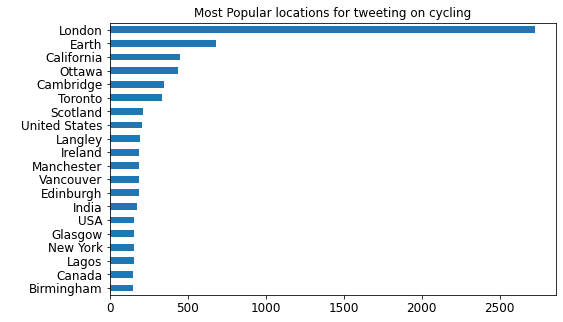

In [73]:
# Visualise the top 20 places where people are located when tweeting about cycling
user_locs.plot.barh(x="location", y="count", title="Most Popular locations for tweeting on cycling", 
                   figsize=(8,5), legend=False, fontsize=12, xlabel=' ' )

# People from c.8,900 unique places are tweeting on cycling
# Earth cannot be defined but will retain to not distort the findings
# Can see that out of c.49,500 tweets examined, the most (2500+) from a single location are from London
# 5% of all people tweeting about cycling globally are readily identifiable as being from London
# This is very significant share for one city & also vastly outstrips the second most popular location
# The second most popular & clearly identifiable location is California (c.400 people)

# Exploring supplied Data for insights

## Load the Data

In [74]:
# Load the CSV file(s) for count data only.
ny_counts = pd.read_csv('NY_Bicycle_Counts.csv', parse_dates=['date'], date_parser=d_parser)
inner_london = pd.read_csv('Inner_London.csv')
central_london = pd.read_csv('Central_London.csv')
outer_london = pd.read_csv('Outer_London.csv')
sydney_counts = pd.read_csv('Sydney_count_surveys.csv')

## Data Wrangling

### Explore the data

In [75]:
# View the DataFrame, metadata, shape
ny_counts.info()
inner_london.info()
central_london.info()
outer_london.info()
sydney_counts.info()

# ny_counts is a large but simple Df containing the number of bicycles passing through a counter
# No missing data in ny_counts  
# Non-Null values for London DataFrames(Df) across all columns dont add up. 
# Implies missing data.
# Will need to explore further.
# Central London is another very large Df
# Large Dfs need to be trimmed for unncessary data to reduce strain on memory use.
# Sydney observations are just aggregated by month and SiteID
# Sydney observations run for selected hours and not all day (looks like peak hours only)
# Sydney also has no missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167507 entries, 0 to 4167506
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   id      int64         
 1   date    datetime64[ns]
 2   counts  int64         
 3   status  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 127.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615168 entries, 0 to 615167
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Survey wave (year)          523776 non-null  float64
 1   Site ID                     523776 non-null  object 
 2   Location                    523776 non-null  object 
 3   Survey date                 521024 non-null  object 
 4   Weather                     519102 non-null  object 
 5   Time                        523770 non-null  object 
 6   Period                      523770 non-null  object 
 7   Direction              

In [76]:
# Get more precise handle on missing values in each Df
inner_london.isnull().sum()

Survey wave (year)            91392
Site ID                       91392
Location                      91392
Survey date                   94144
Weather                       96066
Time                          91398
Period                        91398
Direction                     91392
Start hour                    91398
Start minute                  91398
Number of private cycles      91392
Number of cycle hire bikes    91392
Total cycles                  91392
dtype: int64

In [77]:
# Get more precise handle on missing values in each Df
central_london.isnull().sum()

Survey wave (calendar quarter)     290203
Equivalent financial quarter       290203
Site ID                            290203
Location                           290203
Survey date                        300359
Weather                            302037
Time                               290203
Period                             290203
Direction                          290203
Start hour                         290203
Start minute                       290203
Number of private cycles           290267
Number of cycle hire bikes         290267
Total cycles                       290203
Unnamed: 14                       1048366
Unnamed: 15                       1048366
Unnamed: 16                       1048366
dtype: int64

In [78]:
# Get more precise handle on missing values in each Df
outer_london.isnull().sum()

Survey wave (year)             0
Site ID                        0
Location                       0
Survey date                 1168
Weather                      968
Time                           0
Period                         0
Direction                      0
Start hour                     0
Start minute                   0
Number of male cycles          0
Number of female cycles        0
Number of unknown cycles       0
Total cycles                   0
dtype: int64

In [79]:
# Look at samples of the data
ny_counts.head(5)

# Very sparse but clean data
# Id is site Id for where the counter is located
# Data runs until mid June 2022. 
# So data is very recent

,id,date,counts,status
0,100009425,2022-06-24 00:00:00,15,0
1,100009425,2022-06-24 00:15:00,12,0
2,100009425,2022-06-24 00:30:00,14,0
3,100009425,2022-06-24 00:45:00,5,0
4,100009425,2022-06-24 01:00:00,10,0


In [80]:
# Exploring why NY data is so large.
# View Tail to see how long the data runs until
ny_counts.tail(5)

# Data starts from mid Dec 2012
# Need to explore how far the other data sets run until

,id,date,counts,status
4167502,100005020,2012-12-12 02:45:00,3,4
4167503,100005020,2012-12-12 03:00:00,2,4
4167504,100005020,2012-12-12 03:15:00,3,4
4167505,100005020,2012-12-12 03:30:00,1,4
4167506,100005020,2012-12-12 03:45:00,2,4


In [81]:
# Look at samples of the data
inner_london.head(5)

# Date has french word in it. Needs to cleaned.

,Survey wave (year),Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles
0,2015.0,INNCY001,Grove Road,"mer, 20/05/15",Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6.0,0.0,1.0,0.0,1.0
1,2015.0,INNCY001,Grove Road,"mer, 20/05/15",Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,6.0,15.0,2.0,0.0,2.0
2,2015.0,INNCY001,Grove Road,"mer, 20/05/15",Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6.0,30.0,2.0,0.0,2.0
3,2015.0,INNCY001,Grove Road,"mer, 20/05/15",Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,6.0,45.0,4.0,0.0,4.0
4,2015.0,INNCY001,Grove Road,"mer, 20/05/15",Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,7.0,0.0,4.0,0.0,4.0


In [82]:
# Look at samples of the data
central_london.head(5)

# Data similar in format to inner london but has some extra columns.
# Will need to trim this Df to concatenate
# Explore whether we need the extra columns and if not will trim

,Survey wave (calendar quarter),Equivalent financial quarter,Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,6.0,15.0,15.0,0.0,15.0,NaN,NaN,NaN
2,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6.0,30.0,35.0,0.0,35.0,NaN,NaN,NaN
3,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,6.0,45.0,59.0,2.0,61.0,NaN,NaN,NaN
4,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,7.0,0.0,73.0,0.0,73.0,NaN,NaN,NaN


In [83]:
# Look at samples of the data
outer_london.head(5)

# Matches format of inner london.

,Survey wave (year),Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of male cycles,Number of female cycles,Number of unknown cycles,Total cycles
0,2015,OUTCY001,High Road Leyton,"ven, 26/06/15",Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6,0,2,1,0,3
1,2015,OUTCY001,High Road Leyton,"ven, 26/06/15",Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,6,15,3,0,0,3
2,2015,OUTCY001,High Road Leyton,"ven, 26/06/15",Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6,30,2,0,0,2
3,2015,OUTCY001,High Road Leyton,"ven, 26/06/15",Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,6,45,4,0,0,4
4,2015,OUTCY001,High Road Leyton,"ven, 26/06/15",Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,7,0,4,1,0,5


In [84]:
# Look at samples of the data
sydney_counts.head(5)

,SiteID,Month,Year,TotalCount,ObjectId2,Time_0600,Time_0700,Time_0800,Time_1600,Time_1700,Time_1800
0,51,March,2010,263,1,12,45,56,27,56,67
1,1,October,2015,383,2,37,69,100,47,68,62
2,52,March,2010,136,3,7,18,31,29,30,21
3,53,March,2010,333,4,25,86,93,15,62,52
4,2,October,2015,447,5,32,75,72,56,114,98


## Filter & Clean Data

In [85]:
# Rename columns to remove space in column names
inner_london.columns = inner_london.columns.str.replace(' ','_')
central_london.columns = central_london.columns.str.replace(' ','_')
outer_london.columns = outer_london.columns.str.replace(' ','_')
sydney_counts.columns = sydney_counts.columns.str.replace(' ','_')

In [86]:
# Remove French Day name in Survey Date 
inner_london["Survey_date"] = inner_london["Survey_date"].str.replace(r'\D+', '', regex=True)
central_london["Survey_date"] = central_london["Survey_date"].str.replace(r'\D+', '', regex=True)
outer_london["Survey_date"] = outer_london["Survey_date"].str.replace(r'\D+', '', regex=True)

In [87]:
# Drop empty columns
ny_counts.dropna(how='all', axis=1, inplace=True)
inner_london.dropna(how='all', axis=1, inplace=True)
central_london.dropna(how='all', axis=1, inplace=True)
outer_london.dropna(how='all', axis=1, inplace=True)

In [88]:
# Parse London Df Dates into appropriate format
# Convert to datetime format
inner_london['Survey_date'] = pd.to_datetime(inner_london['Survey_date'], dayfirst=True, yearfirst=False)
central_london['Survey_date'] = pd.to_datetime(central_london['Survey_date'], dayfirst=True, yearfirst=False)
outer_london['Survey_date'] = pd.to_datetime(outer_london['Survey_date'], dayfirst=True, yearfirst=False)

# Sort DataFrame by chronological order
inner_london = inner_london.sort_values(['Survey_date', 'Start_hour', 'Start_minute'])
central_london = central_london.sort_values(['Survey_date', 'Start_hour', 'Start_minute'])
outer_london = outer_london.sort_values(['Survey_date', 'Start_hour', 'Start_minute'])

# Replace with value of previous value row where there is a missing value in Survey_date
inner_london['Survey_date'].fillna(method='ffill', inplace=True)
central_london['Survey_date'].fillna(method='ffill', inplace=True)
outer_london['Survey_date'].fillna(method='ffill', inplace=True)

# Define day of the week in English and add back as a column
inner_london['Day_of_week'] = inner_london['Survey_date'].dt.day_name()
central_london['Day_of_week'] = central_london['Survey_date'].dt.day_name()
outer_london['Day_of_week'] = outer_london['Survey_date'].dt.day_name()

# Pass Month into a new column
inner_london['month'] = inner_london['Survey_date'].dt.month
central_london['month'] = central_london['Survey_date'].dt.month
outer_london['month'] = outer_london['Survey_date'].dt.month

# Pass Year into a new column
inner_london['year'] = inner_london['Survey_date'].dt.year
central_london['year'] = central_london['Survey_date'].dt.year
outer_london['year'] = outer_london['Survey_date'].dt.year


In [89]:
# Parse London Df Dates into appropriate format
# Pass Month name into a new column
inner_london['month_name'] = inner_london['Survey_date'].dt.month_name(locale='English')
central_london['month_name'] = central_london['Survey_date'].dt.month_name(locale='English')
outer_london['month_name'] = outer_london['Survey_date'].dt.month_name(locale='English')

In [90]:
# Parse NY DataFrame Dates into appropriate formats
# Extract year information from timestamped date column
ny_counts['year'] = ny_counts['date'].dt.year

# Extract hour information first from timestamped date column
ny_counts['hour'] = ny_counts['date'].dt.hour

# Extract month name from the timestamped date column
ny_counts['month_name'] = ny_counts['date'].dt.month_name(locale='English')

# Extract month number from the timestamped date column
ny_counts['month'] = ny_counts['date'].dt.month

In [91]:
# Pass Season
# Will need this to test for seasonal impact on cycling uptake
# Create function for user defined seasons
def f(x):
    if (x >= 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
inner_london['season'] = inner_london['month'].apply(f)
central_london['season'] = central_london['month'].apply(f)
outer_london['season'] = outer_london['month'].apply(f)

In [92]:
# Cleanup NY Dates
# Make sure that the data is sorted in chronological order without altering anything else for the moment
ny_counts.sort_values(by='date')

# Can see data set runs from 31 Aug 2012 to 04 Jul 2022
# Can extract hour of the day to look for patterns. Expect peak vs off peak patterns
# We can also group the data by day of the week to look for patterns around that
# We can also see that its possible to group the data into month to look for seasonal patterns
# We can also group/subset the data by id which is another spatial/location identifier

,id,date,counts,status,year,hour,month_name,month
2059019,100047029,2012-08-31 00:00:00,41,4,2012,0,August,8
3205445,100062893,2012-08-31 00:00:00,41,4,2012,0,August,8
4164087,100005020,2012-08-31 00:00:00,41,4,2012,0,August,8
2370586,100051865,2012-08-31 00:00:00,41,4,2012,0,August,8
4165734,100005020,2012-08-31 00:15:00,52,4,2012,0,August,8
...,...,...,...,...,...,...,...,...
16707,100062893,2022-07-04 23:45:00,34,0,2022,23,July,7
16803,300020241,2022-07-04 23:45:00,16,0,2022,23,July,7
16995,300024007,2022-07-04 23:45:00,2,0,2022,23,July,7
16323,100047029,2022-07-04 23:45:00,34,0,2022,23,July,7


In [93]:
# Create user defined function for peak and off peak hours to match London Data
# See when and if time of the day matters 
def f(x):
    if (x > 6) and (x <= 7):
        return 'Early Morning'
    elif (x > 7) and (x <= 10 ):
        return 'AM peak'
    elif (x > 10) and (x <= 16):
        return'Inter Peak'
    elif (x > 16) and (x <= 19) :
        return 'PM Peak'
    elif (x > 19) and (x <= 23):
        return'Evening'
    elif (x <= 6):
        return'Night'
    
# Apply user defined function to create new column with peak and off peak hours
ny_counts['time_of_day'] = ny_counts['hour'].apply(f)

In [94]:
# Define day of the week and add as column to match London Data
ny_counts = ny_counts.assign(day_of_week = lambda x: x.date.dt.day_name())

In [95]:
# Define month to calculate user defined seasons to match London
# Extract month information first from timestamped date column
ny_counts['month'] = ny_counts['date'].dt.month

# Create user defined function for seasons
def f(x):
    if (x >= 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
ny_counts['season'] = ny_counts['month'].apply(f)

In [96]:
# Reshaping the order of the columns so they flow more logically within the DataFrame
neworder = ['id', 'date', 'year', 'month', 'month_name', 'season', 
            'day_of_week', 'hour', 'time_of_day', 'counts', 'status']
ny_counts = ny_counts.reindex(columns=neworder)

In [97]:
# Investigate in Ny_counts what status there is
print(ny_counts.status.unique())

# As both status within acceptable boundaries versus data dictionary, can drop status column

[0 4]


In [98]:
# Dropping redundant columns
ny_counts=ny_counts.drop(['status'], axis=1)

In [99]:
# Rename the Sydney columns to align to Peak/off Peak of other Df.
sydney_counts.rename(columns = {"Time_0600":"Early_Morning",
                              "Time_0700":"AM_Peak1",
                              "Time_0800":"AM_Peak2",
                              "Time_1600":"PM_Peak1",
                              "Time_1700":"PM_Peak2",
                              "Time_1800":"PM_Peak3"},
                             inplace=True)

# Add All AM Peak and PM Peak Columns into 2 columns only to align to the way other Dfs are presented
sydney_counts['AM_Peak'] = sydney_counts['AM_Peak1'] + sydney_counts['AM_Peak2'] 
sydney_counts['PM_Peak'] = sydney_counts['PM_Peak1'] + sydney_counts['PM_Peak2'] + sydney_counts['PM_Peak3']

# View Output with 5 random samples 
sydney_counts.sample(5)

# Can consolidate some columns

,SiteID,Month,Year,TotalCount,ObjectId2,Early_Morning,AM_Peak1,AM_Peak2,PM_Peak1,PM_Peak2,PM_Peak3,AM_Peak,PM_Peak
1250,6,October,2013,392,1251,34,64,104,35,101,54,168,190
1199,53,March,2013,513,1200,33,88,118,49,115,110,206,274
2,52,March,2010,136,3,7,18,31,29,30,21,49,80
1121,24,March,2013,118,1122,16,19,18,17,28,20,37,65
2103,55,October,2021,265,2183,18,48,40,47,49,63,88,159


In [100]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
sydney_counts['Sum'] = sydney_counts['AM_Peak'] + sydney_counts['PM_Peak'] + sydney_counts['Early_Morning']

# Dropping rows where the column values dont add up 
sydney_counts = sydney_counts[sydney_counts.TotalCount == sydney_counts.Sum]

In [101]:
# Dropping redundant columns
sydney_counts=sydney_counts.drop(['ObjectId2', 'AM_Peak1', 'AM_Peak2', 'PM_Peak1', 'PM_Peak2', 'PM_Peak3', 'Sum'], axis=1)

In [102]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
inner_london['Sum'] = inner_london['Number_of_private_cycles'] + inner_london['Number_of_cycle_hire_bikes']

# Dropping rows where the column values dont add up 
inner_london = inner_london[inner_london.Total_cycles == inner_london.Sum]

In [103]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
central_london['Sum'] = central_london['Number_of_private_cycles'] + central_london['Number_of_cycle_hire_bikes']

# Dropping rows where the column values dont add up 
central_london = central_london[central_london.Total_cycles == central_london.Sum]

In [104]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
outer_london['Sum'] = outer_london['Number_of_male_cycles'] + outer_london['Number_of_female_cycles'] + outer_london['Number_of_unknown_cycles']

# Dropping rows where the column values dont add up 
outer_london = outer_london[outer_london.Total_cycles == outer_london.Sum]

In [105]:
# Drop the decimal point in Survey_wave
inner_london['Survey_wave_(year)'] = inner_london['Survey_wave_(year)'].astype(str).apply(lambda x: x.replace('.0','')).astype(int)

In [106]:
# Dropping redundant columns
inner_london=inner_london.drop(['Sum', 'Start_hour', 'Start_minute'], axis=1)

In [107]:
# Drop the additional information in Survey wave column 
# alligns with the way this info is presented in the other London datasets.
central_london["Survey_wave_(calendar_quarter)"] = central_london["Survey_wave_(calendar_quarter)"].str.replace(r'\D+', '', regex=True)

# Drop the last number in every row 
central_london['Survey_wave_(calendar_quarter)'] = central_london['Survey_wave_(calendar_quarter)'].astype(str).str[:-1].astype(np.int64)

# Rename Column Name to align with other London Datasets
central_london.rename(columns={'Survey_wave_(calendar_quarter)': 'Survey_wave_(year)'}, inplace = True)

In [108]:
# Dropping redundant columns
central_london=central_london.drop(['Sum', 'Start_hour', 'Start_minute', 'Equivalent_financial_quarter'], axis=1)

In [109]:
# Dropping redundant columns
outer_london=outer_london.drop(['Sum', 'Start_hour', 'Start_minute'], axis=1)

In [110]:
# Count unique values in each column
for col in inner_london:
  print(col,": ", inner_london[col].nunique())

# More site ids vs location
# May imply multiple sites in same location. Does this double count? Need to check!
# Survey period of over 7 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 165 types of weather needs to be consolidated into more manageable fashion

Survey_wave_(year) :  7
Site_ID :  597
Location :  584
Survey_date :  463
Weather :  165
Time :  64
Period :  5
Direction :  4
Number_of_private_cycles :  221
Number_of_cycle_hire_bikes :  28
Total_cycles :  233
Day_of_week :  7
month :  9
year :  7
month_name :  9
season :  3


In [111]:
# Explore the different types of Weather
print(inner_london.Weather.unique())

# Lots of overlaps for e.g. Rain & Wet, Dry/cold and dry Cold.
# Need to classify into much narrower streams. 
# Cannot meaningfully look for patterns amongst 165 weather conditions!

['Dry' 'Fine' 'Sunny' 'Wet' 'Cloudy' 'Cloudy/sunny' 'Dry Wet Road'
 'Cloudy/rain' 'Rain' nan 'Cloudy/dry' 'Dry & Windy' 'Mizzle' 'High Wind'
 'Druy' 'Mix Wet/dry' 'Wet/dry' 'Very Windy' 'Drizzle' 'S.wet' 'S/w' 'Sun'
 'Wet/damp' 'Shower' 'Dry/sunny' 'Windy/rain' 'Dry/sun' 'Dry/overcast'
 'Warm + Dry' 'Dry Warm' 'Light Showers' 'Showers'
 'Dry                         9' 'Dry/hot' 'Dark/cloudy' 'Overcast'
 'Dry Sunny' 'Spitting' 'Wet (shower)' 'Down Pour' 'Heavy Rain'
 'Light Rain' 'Shower/dry' 'Hail Stone' 'Sleet' 'Snow' 'Damp' 'Thunder'
 'Fair' 'Rain/sleet' 'Dull/damp' 'Dry/drizzle' 'Dull' 'Dry-wet' 'Too Cold'
 'Dry Cold' 'Hot' 'Heavy Thunder' 'Drizzle/cloudy' 'Dry/wet' 'Cloud'
 'Sun/cloudy' 'Wet/mix' 'Overcast/rain Heavy Showers' 'Overcast/dry'
 'Bright/dry' 'Dry/cold' 'Hail' 'Wet Road' 'Drizzle/dry' 'Drizzle/rain'
 'Intermittent Showers' 'Rain Shower' 'D' 'N/a' 'Dry Road Still Wet'
 'V Light Drizzle' 'W' 'Drizzle/wet' 'Rainy' 'Warm/dry' 'Dry/v. Windy'
 'Dry Windy' 'Windy' 'Wet/windy' 

In [112]:
# Consolidate descriptions in Weather
# Rain
inner_london['Weather'] = inner_london['Weather'].replace(['Wet','Cloudy/rain','Rain','Mix Wet/dry','Drizzle',
                                                          'Light Showers', 'Mizzle','Windy/rain','Showers',
                                                          'Wet/dry','Wet/damp','Shower','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower'
                                                          'Light Rain','Shower/dry','Spitting','Drizzle/cloudy',
                                                          'Dry/wet','Damp', 'Dry/drizzle','Dull/damp','Dry-wet',
                                                          'Wet/mix', 'Drizzle/wet','Wet/windy','Rain Shower',
                                                          'Intermittent Showers','Cloudy/drizzle','Rain/drizzle',
                                                          'Wet Road','Drizzle/dry','Drizzle/rain','Mixed Sunny + Rain',
                                                          'Wet/rain', 'V Light Drizzle', 'Rainy', 'W','Slight Drizzle',
                                                          'Rain Stopped', 'Stopped Raining','Wet Rain Stopped','Raining/wet',
                                                          'Showery','Overcast/rain','Rain/wet','Rain/showers','Showers/sunny',
                                                          'Drizzle/showers','Wet/stop Raining','Drizzle Rain','Drizzle Wet',
                                                          'Damp/sun','Raining','Dry + Wet','Showers/cloudy','Cloudy/showers',
                                                          'Getting Wet','Wet Road:sun','Dry But Wet Road','Drizze',
                                                          'wet','Wettish','Light Rain','S.wet','S/w',
                                                          'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)','Wet (shower)'],'Rain')

# Good
inner_london['Weather'] = inner_london['Weather'].replace(['Sunny','Cloudy Sunny','Sun Setting','Good','Dry/sunny',
                                                          'Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry', 'Warm + Dry','Dry','Dry                         9',
                                                          'Sunny','Cloudy/sunny','Druy','Dry/hot','Dry Warm',
                                                          'Dry/sun','Dryish','Clear And Dry','Clear and Dry','Dry, Warm',
                                                          'Dry, Sunny, Warm','Cloudy with Clear Intervals','Clear and Warm',
                                                          'Dry But Misty','Sunny & Warm All Day','Clear','Dry + Sunny',
                                                          'Sunny/dry','Dr Ry','Dry Y','D','Warm/dry','Bright/dry','Dry Sunny',
                                                          'Fair','Dry/sun','Cloudy','Sunny Overcast Sunny','Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy'],'Good')



# Damp
inner_london['Weather'] = inner_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle','Light Rain',
                                                           'Lt Rain','Drizzle','Intermittent Drizzle', 'Damp','Getting Dry',
                                                           'Dry & Wet','Slight Drizzle/dry','Dry Road Still Wet'],'Damp')

# Dangerous Conditions
inner_london['Weather'] = inner_london['Weather'].replace(['Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot',
                                                           'Dry (road Wet)','Dry, Sunny, Hot','Very Heavy Rain',
                                                           'Intermittent Heavy Showers','Very Hot/dry','Hot/dry',
                                                           'Storm','Heavy Rain High Winds','V Wet','Rain Heavy',
                                                          'Sunny (hot!)','Heavy Thunder','Overcast/rain Heavy Showers',
                                                          'Too Cold','High Wind','Very Windy','Wet/windy','Wet/v.windy',
                                                           'Wet Hail','Rain/hail','Foggy Wet',
                                                           'Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Rain/sleet','Hail Stone',
                                                          'Hail','Showers/hailstone','Rain/hailstone','Dry Chill','Dry/cold',
                                                           'Dry Cold','Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Dry & Windy',
                                                          'Dry but Cold or Wind','Dry/v. Windy','Dry Windy',
                                                          'Windy At First Then Sunny','Windy Dry',
                                                          'Dry Wet Road','Thunder'],'Dangerous_Conditions')

# Consolidating 'Unknown'
inner_london['Weather'] = inner_london['Weather'].replace(['School Out','N/a','Unknown'],'Unknown')

# Transforming Nan Values into Unknown
# Replacing nan with 'Unknown'
inner_london.Weather = inner_london.Weather.fillna('Unknown')

# Consolidating "Dry Dark" into "Unknown"
inner_london['Weather'] = inner_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry',
                                                           'Dark Dry'],'Unknown')

In [113]:
# Count unique values in each column
for col in central_london:
  print(col,": ", central_london[col].nunique())

# More site ids vs location again.
# May imply multiple sites in same location. Does this double count? Need to check!
# Survey period of 8 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 282 types of weather needs to be consolidated

Survey_wave_(year) :  8
Site_ID :  210
Location :  205
Survey_date :  1596
Weather :  283
Time :  64
Period :  5
Direction :  4
Number_of_private_cycles :  435
Number_of_cycle_hire_bikes :  87
Total_cycles :  479
Day_of_week :  7
month :  12
year :  8
month_name :  12
season :  4


In [114]:
# Consolidate descriptions in Weather
# Rain
central_london['Weather'] = central_london['Weather'].replace(['Wet','Cloudy/rain','Rain','Mix Wet/dry','Drizzle',
                                                          'Light Showers', 'Mizzle','Windy/rain','Showers',
                                                          'Wet/dry','Wet/damp','Shower','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower'
                                                          'Light Rain','Shower/dry','Spitting','Drizzle/cloudy',
                                                          'Dry/wet','Damp', 'Dry/drizzle','Dull/damp','Dry-wet',
                                                          'Wet/mix', 'Drizzle/wet','Wet/windy','Rain Shower',
                                                          'Intermittent Showers','Cloudy/drizzle','Rain/drizzle',
                                                          'Wet Road','Drizzle/dry','Drizzle/rain','Mixed Sunny + Rain',
                                                          'Wet/rain', 'V Light Drizzle', 'Rainy', 'W','Slight Drizzle',
                                                          'Rain Stopped', 'Stopped Raining','Wet Rain Stopped','Raining/wet',
                                                          'Showery','Overcast/rain','Rain/wet','Rain/showers','Showers/sunny',
                                                          'Drizzle/showers','Wet/stop Raining','Drizzle Rain','Drizzle Wet',
                                                          'Damp/sun','Raining','Dry + Wet','Showers/cloudy','Cloudy/showers',
                                                          'Getting Wet','Wet Road:sun','Dry But Wet Road','Drizze',
                                                          'wet','Wettish','Light Rain','S.wet','S/w','Cold/rain',
                                                           'Slightly Wet','Road Wet','Light Shower','Rain Damp','Wet Damp',
                                                              'Wet - Dry','Dry - Wet','Rain Dry','Dry - Rain','Damp - Rain',
                                                              'Wet/ Dry','S. Wet','Cloudy/ Rain','Windy/ Rain','Wet T',
                                                              'Some Showers','Rains','Sunny/rainy','Wetr','Showers Mix',
                                                              'Rain/dry','Rain/cloudy','Shower/wet','Wetter',
                                                              'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)','Wet (shower)','Blustery','V. Wet',
                                                              'Rain & Thunder','Rain-heavy','H Rain','Wert','(rain After)',
                                                              'Cloud/rain','Really Wet','Periods Of Rain Quite Windy',
                                                              'Steady Rain'],'Rain')

# Good
central_london['Weather'] = central_london['Weather'].replace(['Sunny','Cloudy Sunny','Sun Setting','Good','Dry/sunny',
                                                          'Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry', 'Warm + Dry','Dry','Dry                         9',
                                                          'Sunny','Cloudy/sunny','Druy','Dry/hot','Dry Warm',
                                                          'Dry/sun','Dryish','Clear And Dry','Clear and Dry','Dry, Warm',
                                                          'Dry, Sunny, Warm','Cloudy with Clear Intervals','Clear and Warm',
                                                          'Dry But Misty','Sunny & Warm All Day','Clear','Dry + Sunny',
                                                          'Sunny/dry','Dr Ry','Dry Y','D','Warm/dry','Bright/dry','Dry Sunny',
                                                          'Fair','Dry/sun','Kdry','Fine Windy',
                                                               'Cloudy','Sunny Overcast Sunny','Sunny/cloudy',
                                                               'Cloudy/rain/sunny','Cloudy + Sunny','Sunny + Cloudy',
                                                               'Cloudy/sunny','Bright + Cloudy','Cloudy/dry',
                                                               'Partly Sunny','Dull','Dry & Mild','Cloud','Overcast',
                                                               'Mild','Overcast (No Rain)','Cloudy bright intervals',
                                                               'Generally overcast','Cloudy with clear spells',
                                                               'Sunny Overcast','Dry','Dry/mild', 'Clear',
                                                               'Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy','Hazy','Partly Cloudy',
                                                               'Drty','Dry (windy)','Fine (windy)','Sunny Cloudy',
                                                              'Dry Dark','Dark','Dry Mon','Dry Wed','Dry Thu','Dry Fri',
                                                              'Sun/rain','Thunder','Cloudy','Sunny Overcast Sunny',
                                                               'Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy','Hazy','Partly Cloudy',
                                                               'Drty','Dry (windy)','Fine (windy)','Sunny Cloudy',
                                                              'Dry Dark','Dark','Dry Mon','Dry Wed','Dry Thu','Dry Fri',
                                                              'Sun/rain','Thunder','Ddry','Dy','Dry/sunny/cold','Fine Cold',
                                                              'Cold Dry','Dry & Cold','Dry And Fine','Dry And Sunny',
                                                              'Dry And Warm','Fine And Dry','Warm + Sunny','Warm And Humid',
                                                              'Warm And Windy','Overcast And Dull','Cloudy And Warm',
                                                              'Sunny Periods And Warm','Dry And Windy','Dry And Very Windy',
                                                              'Warm Sunny And Windy','Hot And Humid','Mild And Sunny',
                                                               'Warm And Overcast','Sunny & Windy','Windy/cloudy',
                                                              'Dry/gusty','Coldish','Windy/dry','Dry But A Bit Windy',
                                                               'Sunny Cold','Cold At First Then Warm/sunny',
                                                              'Warm & Sunny Chilly Later','Fine + Dry Chilly At First',
                                                               'Fine & Sunny','dry','A Bit Chilly At First',
                                                               'Warm With A Slight Wind','Cold Then Dry And Windy',
                                                               'Dry And Overcast','Warm + Sunny Cloudy + Windy',
                                                              'Dry 3/4 Dry','Sunny Until Evening But Windy',
                                                               'Winds Rather Chilly','Warm','Sunny But Very Windy',
                                                               'Now Starts To Get Chilly'],'Good')


# Light Rain
central_london['Weather'] = central_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle','Light Rain',
                                                           'Lt Rain','Drizzle','Intermittent Drizzle', 'Damp','Getting Dry',
                                                           'Dry & Wet','Slight Drizzle/dry','Wet Intermittently',
                                                               'Light Rain','V Light Rain','Dry Wet Road','Dry A.m Wet P.m',
                                                               'Mist','Road Drying Sun Out','Wetish','Light Shrs',
                                                              'Fine Drizzle','V Light Shrs','L/rain','Rain Stopped-dry',
                                                              'V Lt Rain','V.light Rain','Dry (+brief Speels Of Drizzle',
                                                              'Wet (spitting)','Drizzly Rain','Almost Dry','Damp & Drizzly',
                                                              'Dry Road Wet With Leaves','Wet Drizzle','No Rain Wet Roads',
                                                              'Dry But Wet Roads','Very Light Rain','Light Drizzle',
                                                              'Dry/wet Road Surface','V Light Showers','V. Light Rain',
                                                              'Wet/cloudy','Wet/sunny','Dry Road Still Wet',
                                                              '2 Snowflakes Otherwise Dry','Wet-dry','Dry/drizzly',
                                                              'Wet/light Showers','Wet/drizzle','Wet And Windy',
                                                              'Drizzling','Drizzle Damp','Windy Showery','Wet + Dry',
                                                              'V.light Drizzle','Very Light Drizzle','Drying Up','Wet Again',
                                                              'Cold Sunny Rain','Wet First Then Dry','Wetr First Then Dry',
                                                              'Dry With Intermitent Rain','(drizzle)','Damp/misty/wet',
                                                              'Dry But Rain Threatening','Slight Drizzle Till End',
                                                              'Damp/misty','Cold & Dry Early Rain Later',
                                                              'Wet ','Windy/drizzle','Intermitent Light Showers',
                                                              'Intermitent Light Rain','A Few Rain Showers','Drizzly',
                                                              'Rain Looking Likely','A Few Drops Of Rain'],'Damp')

# Dangerous Weather
central_london['Weather'] = central_london['Weather'].replace(['Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot',
                                                           'Dry (road Wet)','Dry, Sunny, Hot','Very Heavy Rain',
                                                           'Intermittent Heavy Showers','Very Hot/dry','Hot/dry',
                                                           'Storm','Heavy Rain High Winds','V Wet','Rain Heavy',
                                                          'Sunny (hot!)','Heavy Thunder','Overcast/rain Heavy Showers',
                                                          'Too Cold','High Wind','Very Windy','Dry & Very Windy',
                                                              'Very Hot Dry','Wet/windy','Wet/v.windy','Wet Hail',
                                                               'Rain/hail','Foggy Wet',
                                                           'Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Rain/sleet','Hail Stone',
                                                          'Hail','Showers/hailstone','Rain/hailstone','Cold/ Rain',
                                                              'Foggy','Wet & Windy','Wet + Windy','Rain/wind',
                                                              'Wet (windy)','Occasional Lt Snow Shrs',
                                                              'Wet And Very Windy','Dry Chill','Dry/cold','Dry Cold',
                                                               'Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Dry & Windy',
                                                          'Dry but Cold or Wind','Dry/v. Windy','Dry Windy',
                                                          'Windy At First Then Sunny','Windy Dry','Cold Windy Dry',
                                                              'Cold/dry','Some Heavy Showers','Very Cold/dry',
                                                              'Foggy/v Cold','Hail Shower','Snowing','Wet/ Snowing',
                                                              'Heavy Snow','Dry/very Windy','Very Windy & Cold',
                                                              'Wet Light Hailstone','Heavy Showers Throughout Day',
                                                              'High Winds & Spits Of Rain','Fine V Cold',
                                                              'Dry (frost & Fog)','V Cold Showers','Cold/showery',
                                                              'Light Showers Inc Some Hail','Cloudy/hail','Cold Wind',
                                                              'Hot & Sunny','Hot And Sunny','Dry/windy/strong Wind',
                                                              'Hot + Humid','Very Cold Sunny But Windy'],'Dangerous_Conditions')

# Consolidating 'Unknown'
central_london['Weather'] = central_london['Weather'].replace(['School Out','N/a','Unknown','Dark Sunny',
                                                              'Wed','Warm & Sunny But Windy & Cold'],'Unknown')

# Transforming Nan Values into Unknown
# Replacing nan with 'Unknown'
central_london.Weather = central_london.Weather.fillna('Unknown')

# Consolidating "Dry Dark"
central_london['Weather'] = central_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry',
                                                           'Dark Dry', 'X'],'Unknown')

In [115]:
# Count unique values in each column
for col in outer_london:
  print(col,": ", outer_london[col].nunique())

# More site ids vs location
# May imply multiple sites in same location. Need to check for double count.
# Survey period of over 7 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 123 types of weather needs to be consolidated

Survey_wave_(year) :  7
Site_ID :  451
Location :  431
Survey_date :  435
Weather :  124
Time :  64
Period :  5
Direction :  4
Number_of_male_cycles :  55
Number_of_female_cycles :  20
Number_of_unknown_cycles :  11
Total_cycles :  65
Day_of_week :  7
month :  8
year :  7
month_name :  8
season :  3


In [116]:
# Consolidate descriptions in Weather
# Rain
outer_london['Weather'] = outer_london['Weather'].replace(['Wet','Showers','Rain','Cloudy + Rain','Rain & Cloudy',
                                                          'Raining', 'Rain/cloudy','Wet/thunder','Light Showers',
                                                          'Rain/showers','W','Wey','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower',
                                                          'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)'],'Rain')

# Good
outer_london['Weather'] = outer_london['Weather'].replace(['Cloudy','Sunny Overcast Sunny','Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy with clear spells',
                                                          'Sunny Overcast', 'Sunny','Cloudy Sunny','Sun Setting','Good',
                                                           'Dry/sunny','Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry','Warm + Dry','D'],'Good')
# Damp
outer_london['Weather'] = outer_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle',
                                                           'Light Rain','Lt Rain','Drizzle','Intermittent Drizzle', 'Damp',
                                                           'Getting Dry','Dry & Wet','Dry/wet',],'Damp')


# Dangerous Conditions
outer_london['Weather'] = outer_london['Weather'].replace(['Dry Chill','Dry/cold','Dry Cold','Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Wet/windy','Wet/v.windy','Wet Hail',
                                                           'Rain/hail','Foggy Wet','Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot','Dry (road Wet)'],
                                                          'Dangerous_Conditions')

# Replacing nan with 'Unknown'
outer_london.Weather = outer_london.Weather.fillna('Unknown')

# Consolidating "Unknown"
outer_london['Weather'] = outer_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry','Dark Dry', 'N/a'],'Unknown')

In [117]:
# Check for duplicated values in the dataframes
# Duplicates are rows where values across all columns match with another row in the dataframe
duplicateRowsDF_inner_london = inner_london[inner_london.duplicated()]

In [118]:
# View output
print(duplicateRowsDF_inner_london)

# 17,862 rows of duplicates
# Will drop these but once all data cleaning is done

        Survey_wave_(year)   Site_ID          Location Survey_date Weather  \
443977                2021  INNCY070  Hammersmith Road  2021-04-14    Good   
444105                2021  INNCY070  Hammersmith Road  2021-04-14    Good   
443979                2021  INNCY070  Hammersmith Road  2021-04-14    Good   
444107                2021  INNCY070  Hammersmith Road  2021-04-14    Good   
443981                2021  INNCY070  Hammersmith Road  2021-04-14    Good   
...                    ...       ...               ...         ...     ...   
509051                2021  INNCY509      Trinity Road  2021-09-16    Good   
508925                2021  INNCY509      Trinity Road  2021-09-16    Good   
509053                2021  INNCY509      Trinity Road  2021-09-16    Good   
508927                2021  INNCY509      Trinity Road  2021-09-16    Good   
509055                2021  INNCY509      Trinity Road  2021-09-16    Good   

               Time                    Period   Direction  \
44

In [119]:
# Check for duplicated values in the dataframes
# Duplicates are rows where values across all columns match with another row in the dataframe
duplicateRowsDF_central_london = central_london[central_london.duplicated()]

In [120]:
# View output
print(duplicateRowsDF_central_london)

# 431 rows of duplicates
# Will drop these but once all data cleaning is done

        Survey_wave_(year)   Site_ID                            Location  \
50522                 2014  CENCY198  Riverside Walk (Albert Embankment)   
50586                 2014  CENCY198  Riverside Walk (Albert Embankment)   
50523                 2014  CENCY198  Riverside Walk (Albert Embankment)   
50587                 2014  CENCY198  Riverside Walk (Albert Embankment)   
50524                 2014  CENCY198  Riverside Walk (Albert Embankment)   
...                    ...       ...                                 ...   
626091                2019  CENCY206                       Warner Street   
626028                2019  CENCY206                       Warner Street   
626092                2019  CENCY206                       Warner Street   
626029                2019  CENCY206                       Warner Street   
626093                2019  CENCY206                       Warner Street   

       Survey_date Weather         Time                    Period   Direction  \
50522 

In [121]:
# Check for duplicated values in the dataframes
# Duplicates are rows where values across all columns match with another row in the dataframe
duplicateRowsDF_outer_london = outer_london[outer_london.duplicated()]

In [122]:
# View output
print(duplicateRowsDF_outer_london)

# No duplicates

Empty DataFrame
Columns: [Survey_wave_(year), Site_ID, Location, Survey_date, Weather, Time, Period, Direction, Number_of_male_cycles, Number_of_female_cycles, Number_of_unknown_cycles, Total_cycles, Day_of_week, month, year, month_name, season]
Index: []


In [123]:
# Check for duplicated rows across all column values
duplicateRowsDF_ny = ny_counts[ny_counts.duplicated()]

In [124]:
# See output of duplication check
print(duplicateRowsDF_ny)

# No duplicates

Empty DataFrame
Columns: [id, date, year, month, month_name, season, day_of_week, hour, time_of_day, counts]
Index: []


In [125]:
# Check for duplicated rows across all column values
duplicateRowsDF_sydney = sydney_counts[sydney_counts.duplicated()]

In [126]:
# See output of duplication check
print(duplicateRowsDF_sydney)

# No duplicates

Empty DataFrame
Columns: [SiteID, Month, Year, TotalCount, Early_Morning, AM_Peak, PM_Peak]
Index: []


### Summarising Null Values

In [127]:
# Check missing values
ny_counts.isnull().sum()

# No Null Values

id             0
date           0
year           0
month          0
month_name     0
season         0
day_of_week    0
hour           0
time_of_day    0
counts         0
dtype: int64

In [128]:
# Check missing values
sydney_counts.isnull().sum()

# No Null Values

SiteID           0
Month            0
Year             0
TotalCount       0
Early_Morning    0
AM_Peak          0
PM_Peak          0
dtype: int64

In [129]:
# Check missing values
inner_london.isnull().sum()

# Just 6 null values in Time 
# Given the overall size of the dataframe, this is not worthwhile trying to investigate.
# Will drop them

Survey_wave_(year)            0
Site_ID                       0
Location                      0
Survey_date                   0
Weather                       0
Time                          6
Period                        6
Direction                     0
Number_of_private_cycles      0
Number_of_cycle_hire_bikes    0
Total_cycles                  0
Day_of_week                   0
month                         0
year                          0
month_name                    0
season                        0
dtype: int64

In [130]:
# Check missing values
central_london.isnull().sum()

# No Null Values

Survey_wave_(year)            0
Site_ID                       0
Location                      0
Survey_date                   0
Weather                       0
Time                          0
Period                        0
Direction                     0
Number_of_private_cycles      0
Number_of_cycle_hire_bikes    0
Total_cycles                  0
Day_of_week                   0
month                         0
year                          0
month_name                    0
season                        0
dtype: int64

In [131]:
# Check missing values
outer_london.isnull().sum()

# No Null Values

Survey_wave_(year)          0
Site_ID                     0
Location                    0
Survey_date                 0
Weather                     0
Time                        0
Period                      0
Direction                   0
Number_of_male_cycles       0
Number_of_female_cycles     0
Number_of_unknown_cycles    0
Total_cycles                0
Day_of_week                 0
month                       0
year                        0
month_name                  0
season                      0
dtype: int64

In [132]:
# Review all metadata again 
ny_counts.info()
inner_london.info()
central_london.info()
outer_london.info()
sydney_counts.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167507 entries, 0 to 4167506
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   year         int64         
 3   month        int64         
 4   month_name   object        
 5   season       object        
 6   day_of_week  object        
 7   hour         int64         
 8   time_of_day  object        
 9   counts       int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 318.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 523624 entries, 17408 to 378879
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Survey_wave_(year)          523624 non-null  int32         
 1   Site_ID                     523624 non-null  object        
 2   Location                    523624 non-n

In [133]:
ny_counts.head()

,id,date,year,month,month_name,season,day_of_week,hour,time_of_day,counts
0,100009425,2022-06-24 00:00:00,2022,6,June,Summer,Friday,0,Night,15
1,100009425,2022-06-24 00:15:00,2022,6,June,Summer,Friday,0,Night,12
2,100009425,2022-06-24 00:30:00,2022,6,June,Summer,Friday,0,Night,14
3,100009425,2022-06-24 00:45:00,2022,6,June,Summer,Friday,0,Night,5
4,100009425,2022-06-24 01:00:00,2022,6,June,Summer,Friday,1,Night,10


## Exploring Distribution of data

### New York

In [134]:
# Group NY Counts Data by year, month, day_of week & time of day
df = ny_counts.groupby(['year'], as_index=False)['counts'].count()
df1= ny_counts.groupby(['month_name', 'month'], as_index=False)['counts'].count()
df2 = ny_counts.groupby(['day_of_week'], as_index=False)['counts'].count()
df3 = ny_counts.groupby(['time_of_day', 'hour'], as_index=False)['counts'].count()
df4 = ny_counts.groupby(['year', 'month'], as_index=False)['counts'].count()

In [135]:
# Display the count distribution
df.head(50)

# Can see lots of unevenness of distribution of counts
# For e.g. Sep 2012 has 11,520 counts vs Sep 2013 which has just 2,829 & Sep 2014 which 31,680 counts
# Sep 2015 has 34,560 & Sep 16 has 37,440 counts.

,year,counts
0,2012,47196
1,2013,58513
2,2014,361160
3,2015,405602
4,2016,453021
5,2017,508820
6,2018,541335
7,2019,526548
8,2020,507162
9,2021,499470


In [136]:
# Sort values
df1.sort_values('month', inplace=True)
df3.sort_values('hour', inplace=True)

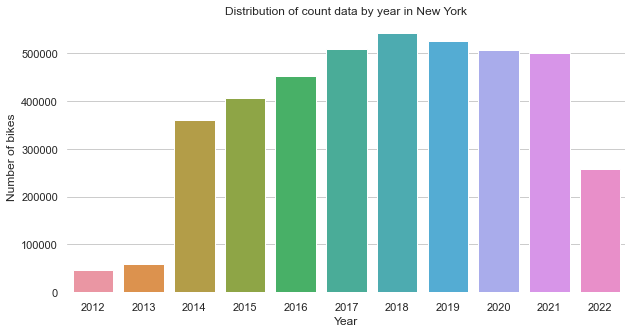

In [137]:
# Visualise NY Counts data distribution by year
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df['year'], y = df['counts'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Year")
g.set_title('Distribution of count data by year in New York')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# We dont have equal amounts of count data across the years

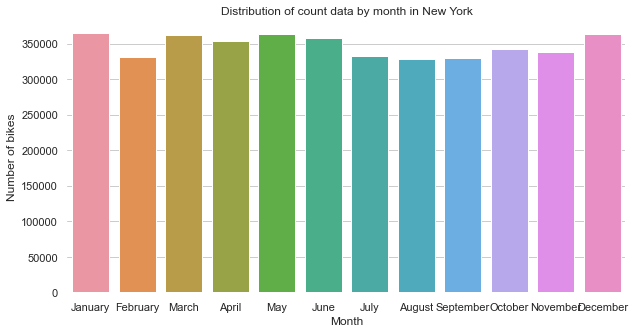

In [138]:
# Visualise NY Counts data distribution by month
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df1['month_name'], y = df1['counts'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Month")
g.set_title('Distribution of count data by month in New York')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Somewhat uneven but within an acceptable range given scale

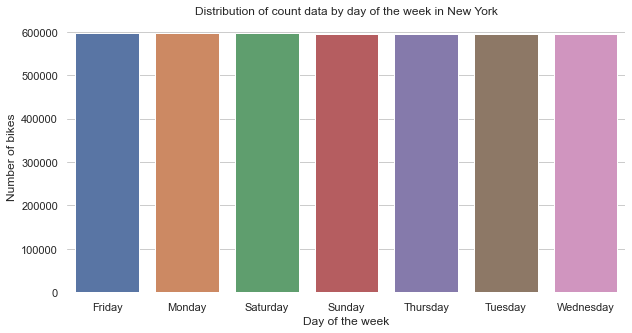

In [139]:
# Visualise NY Counts data distribution by day of the week
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df2['day_of_week'], y = df2['counts'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Day of the week")
g.set_title('Distribution of count data by day of the week in New York')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Equal

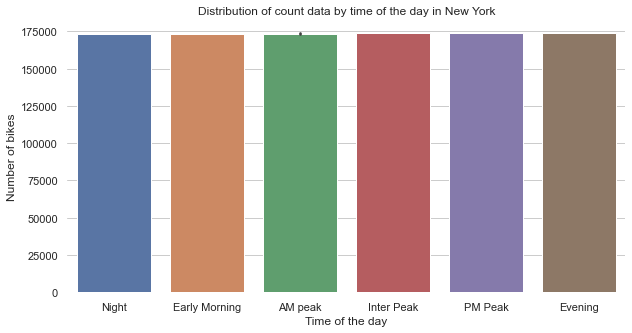

In [140]:
# Visualise Ny Counts by time of day
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df3['time_of_day'], y = df3['counts'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Time of the day")
g.set_title('Distribution of count data by time of the day in New York')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Equal

### London

Inner London

In [141]:
# Group the data 
df = inner_london.groupby(['year'], as_index=False)['Total_cycles'].count()
df1= inner_london.groupby(['month_name', 'month'], as_index=False)['Total_cycles'].count()
df2 = inner_london.groupby(['Day_of_week'], as_index=False)['Total_cycles'].count()
df3 = inner_london.groupby(['Period', 'Time'], as_index=False)['Total_cycles'].count()

In [142]:
# Sort values
df1.sort_values('month', inplace=True)
df3.sort_values('Time', inplace=True)

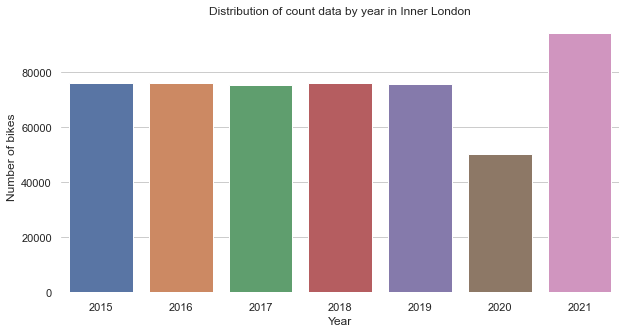

In [146]:
# Visualise Inner London counts data distribution by year
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df['year'], y = df['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Year")
g.set_title('Distribution of count data by year in Inner London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# We dont have equal amounts of count data across the years

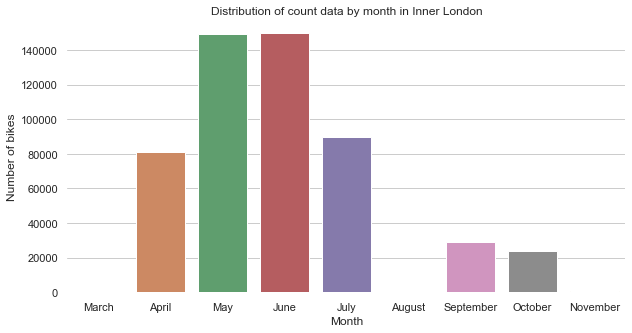

In [144]:
# Visualise Inner London count data distribution by month
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df1['month_name'], y = df1['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Month")
g.set_title('Distribution of count data by month in Inner London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# No Data for months not displayed on x axis
# Dec, Jan & Feb
# Very little data for months where chart displays white bars
# White bars in these months mean the count is too small to scale effectively
# These months are Mar, Aug & Nov

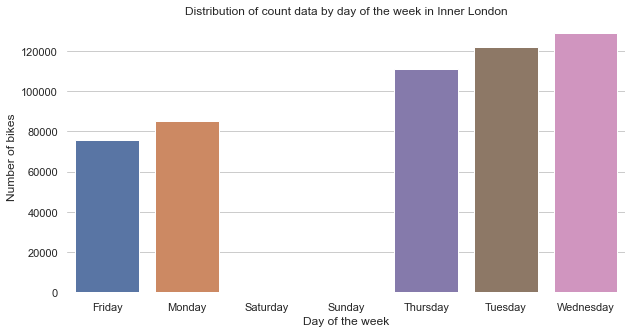

In [145]:
# Visualise Inner London counts data distribution by day of the week
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df2['Day_of_week'], y = df2['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Day of the week")
g.set_title('Distribution of count data by day of the week in Inner London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Very uneven distribution although counts present every day
# Weekends clearly very uneven

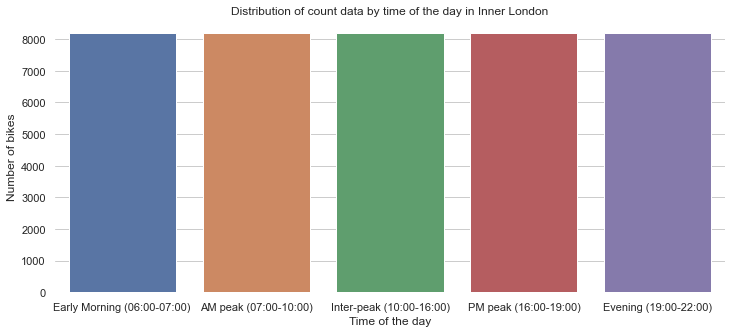

In [147]:
# Visualise Inner London by time of day
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (12,5))

g=sns.barplot(x = df3['Period'], y = df3['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Time of the day")
g.set_title('Distribution of count data by time of the day in Inner London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Equal

Outer London

In [148]:
# Group the data 
df = outer_london.groupby(['year'], as_index=False)['Total_cycles'].count()
df1= outer_london.groupby(['month_name', 'month'], as_index=False)['Total_cycles'].count()
df2 = outer_london.groupby(['Day_of_week'], as_index=False)['Total_cycles'].count()
df3 = outer_london.groupby(['Period', 'Time'], as_index=False)['Total_cycles'].count()

In [149]:
# Sort values
df1.sort_values('month', inplace=True)
df3.sort_values('Time', inplace=True)

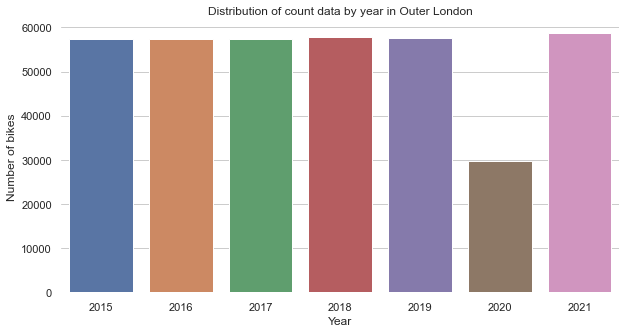

In [150]:
# Visualise Outer London counts data distribution by year
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df['year'], y = df['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Year")
g.set_title('Distribution of count data by year in Outer London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# We dont have equal amounts of count data across the years
# Matches the distribution shape of Inner London

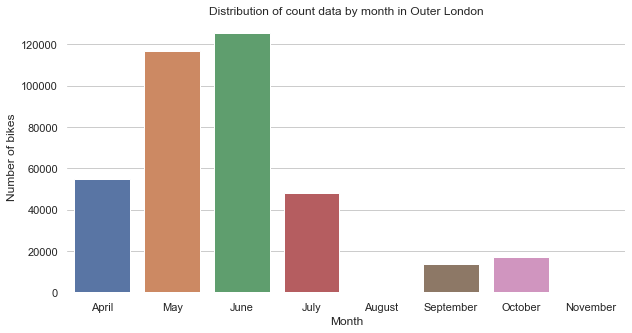

In [151]:
# Visualise Outer London count data distribution by month
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df1['month_name'], y = df1['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Month")
g.set_title('Distribution of count data by month in Outer London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# No Data for months not displayed on x axis
# Dec, Jan Feb & Mar
# Very little data for months where chart displays white bars
# White bars in these months mean the count is too small to scale effectively
# These months are Aug & Nov
# Similar distribution to Inner London

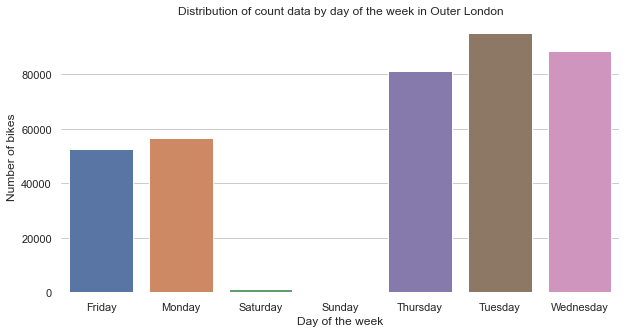

In [152]:
# Visualise Outer London counts data distribution by day of the week
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df2['Day_of_week'], y = df2['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Day of the week")
g.set_title('Distribution of count data by day of the week in Outer London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Very uneven distribution although counts present every day
# Weekends clearly very uneven
# Again similar distribution to Inner London

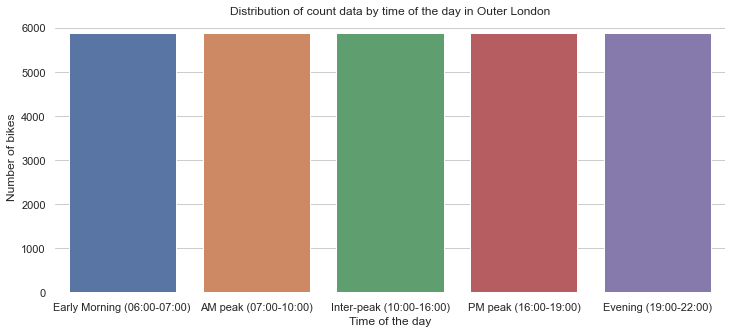

In [153]:
# Visualise Outer London by time of day
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (12,5))

g=sns.barplot(x = df3['Period'], y = df3['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Time of the day")
g.set_title('Distribution of count data by time of the day in Outer London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Equal

Central London

In [154]:
# Group the data 
df = central_london.groupby(['year'], as_index=False)['Total_cycles'].count()
df1= central_london.groupby(['month_name', 'month'], as_index=False)['Total_cycles'].count()
df2 = central_london.groupby(['Day_of_week'], as_index=False)['Total_cycles'].count()
df3 = central_london.groupby(['Period', 'Time'], as_index=False)['Total_cycles'].count()

In [155]:
# Sort values to improve chart presentation
df1.sort_values('month', inplace=True)
df3.sort_values('Time', inplace=True)

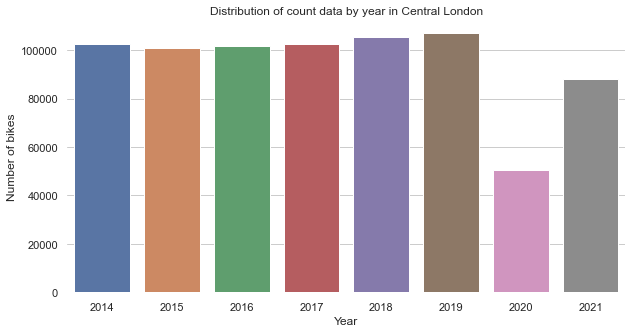

In [156]:
# Visualise Central London counts data distribution by year
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df['year'], y = df['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Year")
g.set_title('Distribution of count data by year in Central London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Reasonably equal distribution
# Except 2020 which again matches Inner London where there is a dip in number of counts too
# Therefore during Covid this count service was impacted
# Data Collection should be automated

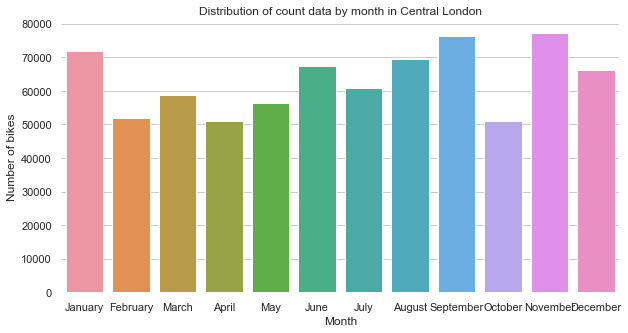

In [157]:
# Visualise Central London count data distribution by month
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df1['month_name'], y = df1['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Month")
g.set_title('Distribution of count data by month in Central London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Unequal distribution
# Data missing without any clear pattern
# But data is there across all months

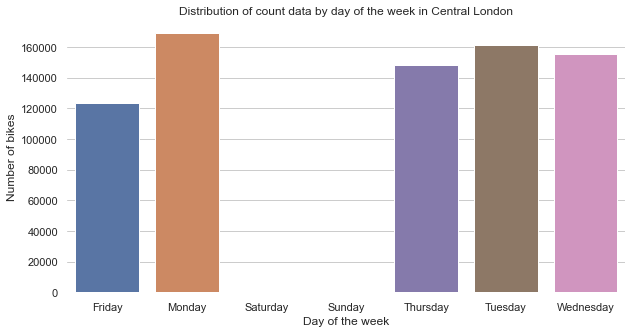

In [158]:
# Visualise Central London counts data distribution by day of the week
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df2['Day_of_week'], y = df2['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Day of the week")
g.set_title('Distribution of count data by day of the week in Central London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Very uneven distribution although counts present every day
# Weekends clearly very uneven
# Again similar distribution to Inner & Outer London here

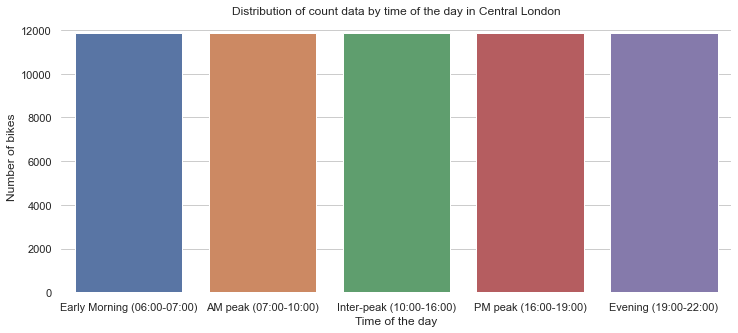

In [159]:
# Visualise Central London by time of day
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (12,5))

g=sns.barplot(x = df3['Period'], y = df3['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Time of the day")
g.set_title('Distribution of count data by time of the day in Central London')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Equal

Sydney

In [160]:
# Group the data 
df = sydney_counts.groupby(['Year'], as_index=False)['TotalCount'].count()
df1= sydney_counts.groupby(['Month'], as_index=False)['TotalCount'].count()
df2 = sydney_counts.groupby(['SiteID'], as_index=False)['TotalCount'].count()

In [161]:
# Sort values to improve chart presentation
df.sort_values('Year', inplace=True)
df1.sort_values('Month', inplace=True)

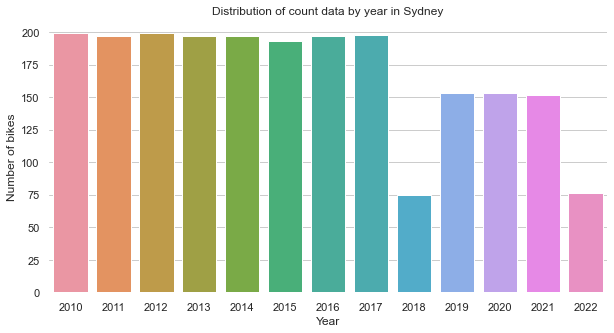

In [162]:
# Visualise Sydney counts data distribution by year
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df['Year'], y = df['TotalCount'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Year")
g.set_title('Distribution of count data by year in Sydney')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Sydney very consistent until 2017
# Sudden drop in count of counts after then
# What happened? Why did Sydney stop counting?
# Pick up of count data in Sydnet again 2019 
# Again pretty uniform albeit consistenly fewer counts compared to pre-2018
# Was there a policy shift in 2018 w.r.t. cycling & thus resources pointed towards counting?

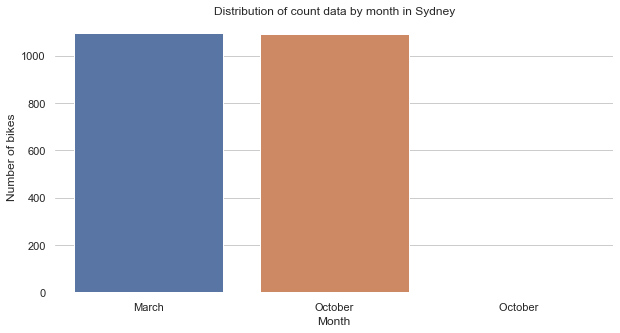

In [163]:
# Visualise Sydney count data distribution by month
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (10,5))

g=sns.barplot(x = df1['Month'], y = df1['TotalCount'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Month")
g.set_title('Distribution of count data by month in Sydney')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Equally distributed

## Data Imputation or Deletion

In [164]:
# New York & London have similar missingness
# Only gap is weekend data
# Strip New York of all weekend data
# Will then allow direct comparison between the cities
# Must return to this after lo-fi to revisit deletion vs imputation
# Should test for type of missing data: most of the missingness has clear patterns 
# Such as missing data on weekends or some months only means MAR
# Some of the unevenness of data is also MCAR such as unevenesss between months in New York
# Most of the missing data in London is MAR
# Sydney needs analysis too; most likely MAR but need to do background research
# Given most of the data is MAR, statistical theory suggests imputation as resolution
# Group unclear/uncomfortable with imputation given no one is a subject matter expert on cycling data
# Assumptions therefore could be incorrect or create unintended bias.
# Need to decide imputation method- simple such as mode or interpolation vs complex such as Mutliple Imputation
# For now decision is to delete data to create more comparable data sets.
# Need to revisit this again post lo-fi

In [165]:
# Drop all rows in New York Count where day of the week is saturday or sunday
# This will align to fact London has no weekend data
# Generates a more like for like comparison between New York and London
# Drop rows containing Saturday or Sunday in day_of_week
ny_counts = ny_counts[ny_counts["day_of_week"].str.contains("Saturday|Sunday") == False]

In [166]:
# Saving the DataFrames to csv
ny_counts.to_csv('ny_counts_Saurav_151022.csv')
sydney_counts.to_csv('sydney_counts_Saurav_071022.csv')

# Data now is cleaned
# Data will be saved
# No outlier detection carried
# Data is assumed to be ok but again we should test for this ahead of final presentation
# If further analysis doesnt obviously make sense will return for outlier detection

## Merging DataFrames

### Concatenate London DataFrames

In [167]:
# Merging London Dataframes first to check output as this is the base Df. 
london = pd.concat([outer_london, central_london, inner_london])

In [168]:
# View Metadata
london.info()

# London rows all add up correctly so merge is successful. 
# Expecting some null values now as inner and central london dfs didnt have gender info
# Expecting some null values now as outer london df didnt have cycle ownership/rental info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657382 entries, 36736 to 378879
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Survey_wave_(year)          1657382 non-null  int64         
 1   Site_ID                     1657382 non-null  object        
 2   Location                    1657382 non-null  object        
 3   Survey_date                 1657382 non-null  datetime64[ns]
 4   Weather                     1657382 non-null  object        
 5   Time                        1657376 non-null  object        
 6   Period                      1657376 non-null  object        
 7   Direction                   1657382 non-null  object        
 8   Number_of_male_cycles       375659 non-null   float64       
 9   Number_of_female_cycles     375659 non-null   float64       
 10  Number_of_unknown_cycles    375659 non-null   float64       
 11  Total_cycles         

In [169]:
# Check missing values
london.isnull().sum()

# All aligns as expected. 
# Will drop the 6 rows where period and time has null values
# 6 rows being deleted will not impact data with 1.287mio rows and doesnt merit time to investigate these.
# Gender & Cycle ownership data was already missing from some of the original data.
# The missing rows add up to the sum of the original data where the data was missing

Survey_wave_(year)                  0
Site_ID                             0
Location                            0
Survey_date                         0
Weather                             0
Time                                6
Period                              6
Direction                           0
Number_of_male_cycles         1281723
Number_of_female_cycles       1281723
Number_of_unknown_cycles      1281723
Total_cycles                        0
Day_of_week                         0
month                               0
year                                0
month_name                          0
season                              0
Number_of_private_cycles       375659
Number_of_cycle_hire_bikes     375659
dtype: int64

In [170]:
# Dropping the 6 rows where missing values in Time column
london = london.dropna(subset=['Time'])

In [171]:
# Merging the Count Data from london with spatial data
# Pull in the Spatial data
bike_site = pd.read_excel("London_Biking_sites_reconv.xlsx")

# Contains additional data 
# The base data's spatial information has been converted into Longtitude & Latitude

In [172]:
# Look at Metadata
bike_site.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023 entries, 0 to 2022
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UnqID                    2023 non-null   object 
 1   ProgID                   2023 non-null   object 
 2   SurveyDescription        2023 non-null   object 
 3   Easting                  2023 non-null   float64
 4   Northing                 2023 non-null   float64
 5   latitude                 2023 non-null   float64
 6   longitude                2023 non-null   float64
 7   Location                 2023 non-null   object 
 8   Borough                  2023 non-null   object 
 9   Functional cycling area  2021 non-null   object 
dtypes: float64(4), object(6)
memory usage: 158.2+ KB


In [173]:
# Check for duplicates in bike sites info
duplicateRowsDF_bike_sites = bike_site[bike_site.duplicated()]

In [174]:
# View output from duplicate check
print(duplicateRowsDF_bike_sites)

# No duplicate values in bike sites info

Empty DataFrame
Columns: [UnqID, ProgID, SurveyDescription, Easting, Northing, latitude, longitude, Location, Borough, Functional cycling area]
Index: []


In [175]:
# Check missing values
bike_site.isnull().sum()

# Two rows with missing values
# Again give size of dataset these can be dropped without further investigation

UnqID                      0
ProgID                     0
SurveyDescription          0
Easting                    0
Northing                   0
latitude                   0
longitude                  0
Location                   0
Borough                    0
Functional cycling area    2
dtype: int64

In [176]:
# View Data Sample
bike_site.sample(5)

,UnqID,ProgID,SurveyDescription,Easting,Northing,latitude,longitude,Location,Borough,Functional cycling area
1241,MHPCY068,MHPCY,Mini Holland cycle surveys,533870.160000,196434.510000,51.650780,-0.066344,Southbury Road (mid),Enfield,Outer
1353,OUTCY070,OUTCY,Outer area cycle surveys,541647.667954,165123.453158,51.367512,0.033443,Croydon Road,Bromley,Outer
98,CENCY100,CENCY,Central area cycle surveys,532590.210000,182274.500000,51.523836,-0.090178,Bunhill Row,Islington,Central
1646,OUTCY363,OUTCY,Outer area cycle surveys,517864.954109,181133.560313,51.516842,-0.302707,Mount Park Road,Ealing,Outer
290,CGRCY058,CGRCY,Central Grid surveys,529899.400000,181766.680000,51.519895,-0.129132,Montague Place,Camden,Central


In [177]:
# Renaming Column on spatial data to align with Count Data
bike_site.rename(columns = {"UnqID": "Site_ID"},inplace=True)

In [178]:
# Rename columns to remove space in column names
bike_site.columns = bike_site.columns.str.replace(' ','_')

In [179]:
# Dropping the 2 missing value rows previously identified
bike_site = bike_site.dropna(subset=['Functional_cycling_area'])

In [180]:
# Merge the dataframes
dfs = [bike_site, london]
london_complete = ft.reduce(lambda left, right: pd.merge(left, right, on='Site_ID'), dfs)

In [181]:
# Check for duplicates in merged Df 
# Merged Df created using new library
duplicateRowsDF_london_complete = london_complete[london_complete.duplicated()]

In [182]:
# View output of duplicate check
print(duplicateRowsDF_london_complete)

# Can see no new duplicates created as a result of the merge
# Supports that merge is successful

          Site_ID ProgID           SurveyDescription    Easting  Northing  \
112388   CENCY031  CENCY  Central area cycle surveys  532836.82  180658.1   
112389   CENCY031  CENCY  Central area cycle surveys  532836.82  180658.1   
112392   CENCY031  CENCY  Central area cycle surveys  532836.82  180658.1   
112393   CENCY031  CENCY  Central area cycle surveys  532836.82  180658.1   
112396   CENCY031  CENCY  Central area cycle surveys  532836.82  180658.1   
...           ...    ...                         ...        ...       ...   
1277228  INNCY592  INNCY    Inner area cycle surveys  537369.00  181594.0   
1277230  INNCY592  INNCY    Inner area cycle surveys  537369.00  181594.0   
1277232  INNCY592  INNCY    Inner area cycle surveys  537369.00  181594.0   
1277234  INNCY592  INNCY    Inner area cycle surveys  537369.00  181594.0   
1277236  INNCY592  INNCY    Inner area cycle surveys  537369.00  181594.0   

          latitude  longitude                                   Location_x 

In [183]:
# View Metadata of combined df
london_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657376 entries, 0 to 1657375
Data columns (total 28 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Site_ID                     1657376 non-null  object        
 1   ProgID                      1657376 non-null  object        
 2   SurveyDescription           1657376 non-null  object        
 3   Easting                     1657376 non-null  float64       
 4   Northing                    1657376 non-null  float64       
 5   latitude                    1657376 non-null  float64       
 6   longitude                   1657376 non-null  float64       
 7   Location_x                  1657376 non-null  object        
 8   Borough                     1657376 non-null  object        
 9   Functional_cycling_area     1657376 non-null  object        
 10  Survey_wave_(year)          1657376 non-null  int64         
 11  Location_y              

In [184]:
# View Sample
london_complete.head(5)

,Site_ID,ProgID,SurveyDescription,Easting,Northing,latitude,longitude,Location_x,Borough,Functional_cycling_area,...,Number_of_female_cycles,Number_of_unknown_cycles,Total_cycles,Day_of_week,month,year,month_name,season,Number_of_private_cycles,Number_of_cycle_hire_bikes
0,CENCY001,CENCY,Central area cycle surveys,530251.49,178742.45,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,...,NaN,NaN,9.0,Wednesday,1,2014,January,Winter,7.0,2.0
1,CENCY001,CENCY,Central area cycle surveys,530251.49,178742.45,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,...,NaN,NaN,10.0,Wednesday,1,2014,January,Winter,8.0,2.0
2,CENCY001,CENCY,Central area cycle surveys,530251.49,178742.45,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,...,NaN,NaN,11.0,Wednesday,1,2014,January,Winter,11.0,0.0
3,CENCY001,CENCY,Central area cycle surveys,530251.49,178742.45,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,...,NaN,NaN,9.0,Wednesday,1,2014,January,Winter,8.0,1.0
4,CENCY001,CENCY,Central area cycle surveys,530251.49,178742.45,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,...,NaN,NaN,12.0,Wednesday,1,2014,January,Winter,11.0,1.0


In [185]:
# Check if Site ID & Prog ID are identical on string test.
# Strip integers from SiteID into a column containing just the string values
london_complete['Id_Check']= london_complete['Site_ID'].str.replace('\d+', '')
# View Sample
london_complete.sample(5)

,Site_ID,ProgID,SurveyDescription,Easting,Northing,latitude,longitude,Location_x,Borough,Functional_cycling_area,...,Number_of_unknown_cycles,Total_cycles,Day_of_week,month,year,month_name,season,Number_of_private_cycles,Number_of_cycle_hire_bikes,Id_Check
822886,INNCY070,INNCY,Inner area cycle surveys,524034.428263,178735.806663,51.493972,-0.214687,Hammersmith Road,Hammersmith & Fulham,Inner,...,NaN,31.0,Wednesday,10,2020,October,Autumn,26.0,5.0,INNCY
1641180,OUTCY432,OUTCY,Outer area cycle surveys,523813.815163,168773.798258,51.404488,-0.221336,Whatley Avenue,Merton,Outer,...,0.0,0.0,Monday,7,2017,July,Summer,NaN,NaN,OUTCY
842855,INNCY092,INNCY,Inner area cycle surveys,537388.813563,176162.773186,51.467765,-0.023426,Lewisham Way,Lewisham,Inner,...,NaN,2.0,Monday,4,2019,April,Spring,2.0,0.0,INNCY
1551363,OUTCY323,OUTCY,Outer area cycle surveys,536373.541474,168184.436961,51.396307,-0.041098,Balmoral Avenue,Bromley,Outer,...,0.0,1.0,Wednesday,5,2018,May,Spring,NaN,NaN,OUTCY
1514681,OUTCY277,OUTCY,Outer area cycle surveys,519675.561281,193393.251013,51.626639,-0.272447,Glengall Road,Barnet,Outer,...,0.0,0.0,Monday,5,2017,May,Spring,NaN,NaN,OUTCY


In [186]:
# Check the stripped strings for match with ProgID
# If no match, output into new column will be FALSE
london_complete['Equality_Test'] = london_complete['Id_Check'].equals(london_complete['ProgID'])

# Isolating the different unique values in this column
uniqueValues = london_complete['Equality_Test'].nunique()

# Displaying the number of  unique values
print(london_complete["Equality_Test"].unique())

# Established that ProgID (which contains strings only) is duplicate of Site_ID
# ProgID can be dropped

[ True]


In [187]:
# Remove overlapping spatial data
london_complete = london_complete.drop(['ProgID', 'Easting', 'Northing', 'Location_y', 'Id_Check',
                                       'Equality_Test'], axis=1)

In [188]:
# Change all column names to lower case to ease recalling them for analysis
london_complete = london_complete.rename(columns=str.lower)

In [189]:
# Rename some columns to more logical names without changing underlying data dictionary
london_complete = london_complete.rename(columns={'location_x': 'location', 'survey_wave_(year)': 'survey_year'})

In [190]:
# Drop all rows with duplicate values
london_complete.drop_duplicates()

# All duplicate rows dropped
# Returns the number of rows expected
# Data now is cleaned
# Data will be saved
# No outlier detection carried out as data sourced from Tfl and was presented semi wrangled
# If further analysis doesnt obviously make sense will return for outlier detection

,site_id,surveydescription,latitude,longitude,location,borough,functional_cycling_area,survey_year,survey_date,weather,...,number_of_female_cycles,number_of_unknown_cycles,total_cycles,day_of_week,month,year,month_name,season,number_of_private_cycles,number_of_cycle_hire_bikes
0,CENCY001,Central area cycle surveys,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,2014,2014-01-22,Good,...,NaN,NaN,9.0,Wednesday,1,2014,January,Winter,7.0,2.0
1,CENCY001,Central area cycle surveys,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,2014,2014-01-22,Good,...,NaN,NaN,10.0,Wednesday,1,2014,January,Winter,8.0,2.0
2,CENCY001,Central area cycle surveys,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,2014,2014-01-22,Good,...,NaN,NaN,11.0,Wednesday,1,2014,January,Winter,11.0,0.0
3,CENCY001,Central area cycle surveys,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,2014,2014-01-22,Good,...,NaN,NaN,9.0,Wednesday,1,2014,January,Winter,8.0,1.0
4,CENCY001,Central area cycle surveys,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,2014,2014-01-22,Good,...,NaN,NaN,12.0,Wednesday,1,2014,January,Winter,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657371,OUTCY451,Outer area cycle surveys,51.424663,-0.307290,Thames Path (Lower Ham Road),Kingston upon Thames,Outer,2021,2021-06-18,Rain,...,0.0,0.0,1.0,Friday,6,2021,June,Summer,NaN,NaN
1657372,OUTCY451,Outer area cycle surveys,51.424663,-0.307290,Thames Path (Lower Ham Road),Kingston upon Thames,Outer,2021,2021-06-18,Rain,...,0.0,0.0,2.0,Friday,6,2021,June,Summer,NaN,NaN
1657373,OUTCY451,Outer area cycle surveys,51.424663,-0.307290,Thames Path (Lower Ham Road),Kingston upon Thames,Outer,2021,2021-06-18,Rain,...,0.0,0.0,0.0,Friday,6,2021,June,Summer,NaN,NaN
1657374,OUTCY451,Outer area cycle surveys,51.424663,-0.307290,Thames Path (Lower Ham Road),Kingston upon Thames,Outer,2021,2021-06-18,Rain,...,0.0,0.0,0.0,Friday,6,2021,June,Summer,NaN,NaN


In [191]:
# Count unique values in each column
for col in london_complete:
  print(col,": ", london_complete[col].nunique())

# Survey data over 8 years
# Across 1258 counters
# Across 1188 streets
# Across 33 boroughs in London

site_id :  1258
surveydescription :  3
latitude :  1258
longitude :  1258
location :  1188
borough :  33
functional_cycling_area :  3
survey_year :  8
survey_date :  1651
weather :  5
time :  64
period :  5
direction :  4
number_of_male_cycles :  55
number_of_female_cycles :  20
number_of_unknown_cycles :  11
total_cycles :  479
day_of_week :  7
month :  12
year :  8
month_name :  12
season :  4
number_of_private_cycles :  435
number_of_cycle_hire_bikes :  87


In [192]:
# Store the combined dataframe as a new CSV for backup
london_complete.to_csv('london_count_and_site_Saurav_111022.csv')

# Introducing additional Data from independent research

Absent timeseries data on the development of cycling infrastructure in London, some other variables will be analysed which could have a meaningfully quantifiable relationship with cycling uptake. 

- [Private Car Ownership](https://data.london.gov.uk/dataset/licensed-vehicles-numbers-borough "Private Car Ownership") 
- [Traffic Flow](https://data.london.gov.uk/dataset/traffic-flows-borough "Traffic Flow")

Furthermore, to baseline and contextualise the cycling count data, population time series for [London](https://www.macrotrends.net/cities/22860/london/population "London"), [New York](https://www.macrotrends.net/states/new-york/population "New York") and [Sydney](https://www.macrotrends.net/cities/206167/sydney/population "Sydney") are also being introduced.

In [193]:
# Introduce new data
# Traffic and Car Ownership data
car_own = pd.read_csv('private_cars_london.csv')
traffic_flow = pd.read_csv('traffic_flow_borough.csv')

In [194]:
# Population & cycling data
pop_london = pd.read_csv('London_population.csv')
pop_ny = pd.read_csv('New_York_population.csv')
pop_sydney = pd.read_csv('Sydney_population.csv')
london_complete = pd.read_csv('london_count_and_site_Saurav_111022.csv')

In [195]:
# Change all column names to lower case to ease recalling them for analysis
car_own = car_own.rename(columns=str.lower)
traffic_flow = traffic_flow.rename(columns=str.lower)
pop_london = pop_london.rename(columns=str.lower)
pop_ny = pop_ny.rename(columns=str.lower)
pop_sydney = pop_sydney.rename(columns=str.lower)

In [196]:
# Rename columns to remove space in column names
traffic_flow.columns = traffic_flow.columns.str.replace(' ','_')
car_own.columns = car_own.columns.str.replace(' ','_')
pop_london.columns = pop_london.columns.str.replace(' ','_')
pop_ny.columns = pop_ny.columns.str.replace(' ','_')
pop_sydney.columns = pop_sydney.columns.str.replace(' ','_')

In [197]:
# View Sample
pop_london.head()

,date,_population
0,31/12/2014,8537000
1,31/12/2015,8661000
2,31/12/2016,8788000
3,31/12/2017,8916000
4,31/12/2018,9046000


In [198]:
# View Sample
pop_ny.head()

,date,_population
0,01/12/2014,19653431
1,01/12/2015,19657321
2,01/12/2016,19636391
3,01/12/2017,19593849
4,01/12/2018,19544098


In [199]:
# View Sample
pop_sydney.head()

,date,_population
0,31/12/2014,4465000
1,31/12/2015,4544000
2,31/12/2016,4625000
3,31/12/2017,4708000
4,31/12/2018,4792000


## Shaping and cleaning the data for analysis

In [200]:
# Change to datatime format
pop_london['date'] = pd.to_datetime(pop_london['date'], format='%d/%m/%Y')
pop_ny['date'] = pd.to_datetime(pop_ny['date'], format='%d/%m/%Y')
pop_sydney['date'] = pd.to_datetime(pop_sydney['date'], format='%d/%m/%Y')

In [201]:
# Need to create a Year Column in each DF
# Will use this to merge the population data
pop_london['year'] = pop_london['date'].dt.year
pop_ny['year'] = pop_ny['date'].dt.year
pop_sydney['year'] = pop_sydney['date'].dt.year

In [202]:
# Drop date column from each population DF
pop_london.drop('date', axis=1, inplace=True)
pop_ny.drop('date', axis=1, inplace=True)
pop_sydney.drop('date', axis=1, inplace=True)

In [203]:
# View Sample
car_own.head(5)

# Shows absolute numbers of cars registered in private ownership over time in each borough

,year,city_of_london,barking_and_dagenham,barnet,bexley,brent,bromley,camden,croydon,ealing,...,merton,newham,redbridge,richmond_upon_thames,southwark,sutton,tower_hamlets,waltham_forest,wandsworth,westminster
0,2015,2762,64771,145410,111208,99387,155548,50087,145573,122331,...,76593,66964,108099,79178,59240,92461,45234,81307,82755,50779
1,2016,2867,66390,147786,112706,101247,157357,49762,148256,123426,...,78497,69699,109740,79553,59824,93540,46252,83037,83018,50516
2,2017,2658,66887,147703,113172,98444,157146,47781,148184,122672,...,76811,72189,109539,79704,59721,93815,46694,82998,82860,51605
3,2018,2530,67855,147282,112563,97867,156765,43459,148620,121257,...,76159,72411,109045,79062,58935,93650,46405,82200,81981,49714
4,2019,2455,68575,147494,112522,97348,156112,42098,148103,120829,...,73974,72632,109087,78527,58396,93763,46729,81735,81203,49452


In [204]:
# View Sample
traffic_flow.head(5)

# Unit of measure is in millions & kilometers
# Shows million vehicle kilometers travelled by all cars through each borough over time 

,year,city_of_london,barking_and_dagenham,barnet,bexley,brent,bromley,camden,croydon,ealing,...,merton,newham,redbridge,richmond_upon_thames,southwark,sutton,tower_hamlets,waltham_forest,wandsworth,westminster
0,2015,115,512,1405,791,770,1160,377,1075,1059,...,520,704,934,703,537,582,625,608,586,631
1,2016,110,516,1369,803,791,1160,371,1077,1046,...,515,707,938,700,532,587,635,610,572,620
2,2017,105,507,1402,804,784,1155,368,1066,1062,...,509,729,942,702,524,582,642,613,593,608
3,2018,101,504,1396,797,784,1135,359,1062,1057,...,516,731,954,685,509,568,640,652,589,598
4,2019,101,507,1421,814,806,1180,355,1084,1064,...,528,726,952,704,521,585,642,643,607,581


In [205]:
# Merge the population dfs
# Merge the traffic flow and car ownership details
dfs = [pop_london, pop_ny, pop_sydney]
all_pop = ft.reduce(lambda left, right: pd.merge(left, right, on='year'), dfs)

In [206]:
# View output
all_pop

,_population_x,year,_population_y,_population
0,8537000,2014,19653431,4465000
1,8661000,2015,19657321,4544000
2,8788000,2016,19636391,4625000
3,8916000,2017,19593849,4708000
4,9046000,2018,19544098,4792000
5,9177000,2019,19463131,4859000
6,9304000,2020,20154933,4926000
7,9426000,2021,19835913,4992000


In [207]:
# Rename Columns 
all_pop.rename(columns={'_population_x': 'london_pop', '_population_y': 'ny_pop', 
                       '_population': 'sydney_pop'}, inplace=True)

In [208]:
# Create a column showing Y-o-Y % change in population for each city
all_pop['ldn_pop_change'] = pd.DataFrame.pct_change(all_pop['london_pop'])*100
all_pop['ny_pop_change'] = pd.DataFrame.pct_change(all_pop['ny_pop'])*100
all_pop['sydney_pop_change'] = pd.DataFrame.pct_change(all_pop['sydney_pop'])*100

In [209]:
# Create log values for population to reduce the scalar impact on visualisations
all_pop['log_london_pop'] = np.log(all_pop['london_pop'])
all_pop['log_ny_pop'] = np.log(all_pop['ny_pop'])
all_pop['log_sydney_pop'] = np.log(all_pop['sydney_pop'])

In [210]:
# Shape the df for further analysis
all_pop1 = pd.melt(all_pop, id_vars =['year'], value_vars =['log_london_pop', 'log_ny_pop', 'log_sydney_pop'])

In [211]:
# Rename some columns to align across analysis
all_pop1 = all_pop1.rename(columns={'variable': 'location', 'value': 'population(log)', 
                                   'population': 'location'})

In [212]:
# Replace column values to align analysis
all_pop1 = all_pop1.replace(['log_london_pop','log_ny_pop',
                             'log_sydney_pop'],['london', 'new_york', 'sydney'])
all_pop1

,year,location,population(log)
0,2014,london,15.959920
1,2015,london,15.974341
2,2016,london,15.988898
3,2017,london,16.003358
4,2018,london,16.017833
5,2019,london,16.032211
6,2020,london,16.045955
7,2021,london,16.058982
8,2014,new_york,16.793762
9,2015,new_york,16.793960


In [213]:
# Look now at how cycling uptake has evolved in London over the same period
# Introduce the merged london data set and recall the metadata
london_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657376 entries, 0 to 1657375
Data columns (total 25 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Unnamed: 0                  1657376 non-null  int64  
 1   site_id                     1657376 non-null  object 
 2   surveydescription           1657376 non-null  object 
 3   latitude                    1657376 non-null  float64
 4   longitude                   1657376 non-null  float64
 5   location                    1657376 non-null  object 
 6   borough                     1657376 non-null  object 
 7   functional_cycling_area     1657376 non-null  object 
 8   survey_year                 1657376 non-null  int64  
 9   survey_date                 1657376 non-null  object 
 10  weather                     1657376 non-null  object 
 11  time                        1657376 non-null  object 
 12  period                      1657376 non-null  object 
 1

In [214]:
# Look now at how cycling uptake has evolved in London over the same period
# Ensure date is in appropriate format
london_complete['survey_date'] = pd.to_datetime(london_complete.survey_date)

# Aggregate by year
# Insert column year to run aggregation function
london_complete['year'] = london_complete['survey_date'].dt.year

In [215]:
# Fill all NaN values with 0
london_complete.fillna(0)

,Unnamed: 0,site_id,surveydescription,latitude,longitude,location,borough,functional_cycling_area,survey_year,survey_date,...,number_of_female_cycles,number_of_unknown_cycles,total_cycles,day_of_week,month,year,month_name,season,number_of_private_cycles,number_of_cycle_hire_bikes
0,0,CENCY001,Central area cycle surveys,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,2014,2014-01-22,...,0.0,0.0,9.0,Wednesday,1,2014,January,Winter,7.0,2.0
1,1,CENCY001,Central area cycle surveys,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,2014,2014-01-22,...,0.0,0.0,10.0,Wednesday,1,2014,January,Winter,8.0,2.0
2,2,CENCY001,Central area cycle surveys,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,2014,2014-01-22,...,0.0,0.0,11.0,Wednesday,1,2014,January,Winter,11.0,0.0
3,3,CENCY001,Central area cycle surveys,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,2014,2014-01-22,...,0.0,0.0,9.0,Wednesday,1,2014,January,Winter,8.0,1.0
4,4,CENCY001,Central area cycle surveys,51.492629,-0.125179,Millbank (south of Thorney Street),Westminster,Central,2014,2014-01-22,...,0.0,0.0,12.0,Wednesday,1,2014,January,Winter,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657371,1657371,OUTCY451,Outer area cycle surveys,51.424663,-0.307290,Thames Path (Lower Ham Road),Kingston upon Thames,Outer,2021,2021-06-18,...,0.0,0.0,1.0,Friday,6,2021,June,Summer,0.0,0.0
1657372,1657372,OUTCY451,Outer area cycle surveys,51.424663,-0.307290,Thames Path (Lower Ham Road),Kingston upon Thames,Outer,2021,2021-06-18,...,0.0,0.0,2.0,Friday,6,2021,June,Summer,0.0,0.0
1657373,1657373,OUTCY451,Outer area cycle surveys,51.424663,-0.307290,Thames Path (Lower Ham Road),Kingston upon Thames,Outer,2021,2021-06-18,...,0.0,0.0,0.0,Friday,6,2021,June,Summer,0.0,0.0
1657374,1657374,OUTCY451,Outer area cycle surveys,51.424663,-0.307290,Thames Path (Lower Ham Road),Kingston upon Thames,Outer,2021,2021-06-18,...,0.0,0.0,0.0,Friday,6,2021,June,Summer,0.0,0.0


In [216]:
# Simplify df columns
london_complete=london_complete.drop(['Unnamed: 0', 'survey_year', 'site_id', 'time', 'location', 'direction', 
                                      'surveydescription', 'total_cycles'], axis=1)

In [217]:
# Insert a total count in outer london
london_complete['total_outer'] = london_complete['number_of_male_cycles']+london_complete['number_of_female_cycles']+london_complete['number_of_unknown_cycles']

In [218]:
# Insert a total count for inner and central london
london_complete['total_inn_cen'] = london_complete['number_of_private_cycles']+london_complete['number_of_cycle_hire_bikes']

In [219]:
# Fill all NaN values with 0
london_complete['total_outer'] = london_complete['total_outer'].fillna(0)
london_complete['total_inn_cen'] = london_complete['total_inn_cen'].fillna(0)

In [220]:
# Insert a global total uptake column for cycling counts in all areas of london
london_complete['total_uptake'] = london_complete['total_outer']+london_complete['total_inn_cen'] 

In [221]:
# Group by year to see change of total cycling uptake YoY
df= london_complete.groupby(['year'], as_index=False)['total_uptake'].sum()
df

,year,total_uptake
0,2014,1602997.0
1,2015,2138163.0
2,2016,2224386.0
3,2017,2222860.0
4,2018,2420240.0
5,2019,2429084.0
6,2020,1310615.0
7,2021,2119292.0


In [222]:
# Put all numbers on log scale to supress scalar affect
df['log_total_uptake_ldn'] = np.log(df['total_uptake']) 

In [223]:
# Clean the df
df=df.drop(['total_uptake'], axis=1)

In [224]:
# Granularity on how total_uptake evolved in the 3 parts of London
df1= london_complete.groupby(['year', 'functional_cycling_area'], as_index=False)['total_uptake'].sum()

In [225]:
# Visualise the changes
# Put all numbers on log scale to supress scalar affect
df1['log_total_uptake_ldn'] = np.log(df1['total_uptake']) 

In [226]:
# Get overview of how cycling uptake has progressed over the years in New York
df3 = ny_counts.groupby(['year'], as_index=False)['counts'].sum()

In [227]:
# Put all numbers on log scale to supress scalar affects
df3['log_total_uptake_ny'] = np.log(df3['counts']) 

In [228]:
# Clean the df
df3=df3.drop(['counts'], axis=1)

In [229]:
# Change all column names to lower case to ease recalling them for analysis
sydney_counts = sydney_counts.rename(columns=str.lower)

In [230]:
# Get overview of how cycling uptake has progressed over the years in Sydney
df4 = sydney_counts.groupby(['year'], as_index=False)['totalcount'].sum()

In [231]:
# Put all numbers on log scale to supress scalar affects
df4['log_total_uptake_sydney'] = np.log(df4['totalcount']) 
df4

,year,totalcount,log_total_uptake_sydney
0,2010,59772,10.998293
1,2011,79202,11.279757
2,2012,95465,11.466515
3,2013,106150,11.572608
4,2014,114801,11.650955
5,2015,96696,11.479327
6,2016,95464,11.466504
7,2017,101052,11.523391
8,2018,44474,10.702660
9,2019,97270,11.485246


In [232]:
# Df4 shows strange dip in 2018 numbers.
# Investigate further
df4a = sydney_counts.groupby(["year","month"], as_index=False)['totalcount'].sum()
df4a

# March 2018 data missing
# Oct 2018 has duplicate

,year,month,totalcount
0,2010,March,25868
1,2010,October,33904
2,2011,March,37613
3,2011,October,41589
4,2012,March,47203
5,2012,October,48262
6,2013,March,55132
7,2013,October,51018
8,2014,March,59323
9,2014,October,55478


In [233]:
#Drop duplicate
df4a = df4a.drop([17])

In [234]:
# Reshape for correction of missing values
df4a = df4a.pivot(index='year', columns='month', values='totalcount')
df4a.as_index=False
# This inserts March

In [235]:
# Replace missing value with interpolated value 
df4a = df4a.interpolate()

In [236]:
# Reshape the dataframe for further analysis and alignment with other cities
df4a['totalcount'] = df4a['March'] + df4a["October"]
df4a['log_total_uptake_sydney'] = np.log(df4a['totalcount'])
df4a=df4a.drop(['March', 'October', 'totalcount'], axis=1)

# Reset the index
df4 = df4a.reset_index()

In [237]:
# Plot all regions/cities of interest in one chart
# Merge the dataframes
dfs = [df, df3, df4]
on = ['year']
all_counts = ft.reduce(lambda left, right: pd.merge(left, right, on= on), dfs)

In [238]:
# Melt the dataframe to plot all three cities into one chart
df5 = pd.melt(all_counts, id_vars =['year'], value_vars =['log_total_uptake_ldn', 'log_total_uptake_ny', 
                                                         'log_total_uptake_sydney'])
df5.head(5)

,year,variable,value
0,2014,log_total_uptake_ldn,14.287386
1,2015,log_total_uptake_ldn,14.575458
2,2016,log_total_uptake_ldn,14.614991
3,2017,log_total_uptake_ldn,14.614305
4,2018,log_total_uptake_ldn,14.699377


In [239]:
# Rename some columns to align across analysis
df5 = df5.rename(columns={'variable': 'location', 'value': 'cycling_uptake_log'})

In [240]:
# Replace location values to align across analysis
df5 = df5.replace(['log_total_uptake_ldn','log_total_uptake_ny',
                   'log_total_uptake_sydney'],['london', 'new_york', 'sydney'])

In [241]:
# View 
df5.head()

,year,location,cycling_uptake_log
0,2014,london,14.287386
1,2015,london,14.575458
2,2016,london,14.614991
3,2017,london,14.614305
4,2018,london,14.699377


In [242]:
# Merge Population & Cycling Uptake Data across all 3 cities over the period being analysed
dfs = [df5, all_pop1]
on = ['year', 'location']
city_counts = ft.reduce(lambda left, right: pd.merge(left, right, on=on), dfs)
city_counts

,year,location,cycling_uptake_log,population(log)
0,2014,london,14.287386,15.959920
1,2015,london,14.575458,15.974341
2,2016,london,14.614991,15.988898
3,2017,london,14.614305,16.003358
4,2018,london,14.699377,16.017833
5,2019,london,14.703025,16.032211
6,2020,london,14.086007,16.045955
7,2021,london,14.566593,16.058982
8,2014,new_york,15.763577,16.793762
9,2015,new_york,16.156744,16.793960


In [243]:
# Rename columns to remove brackets
city_counts = city_counts.rename(columns={'population(log)': 'population_log'})

In [244]:
# Create a new pivot for cycling uptake
# This will help visualise the cycling and population values in one chart
city_counts_piv_CU = city_counts.pivot(index='year', columns='location', values='cycling_uptake_log')
city_counts_piv_CU = city_counts_piv_CU.reset_index()
city_counts_piv_CU


location,year,london,new_york,sydney
0,2014,14.287386,15.763577,11.650955
1,2015,14.575458,16.156744,11.479327
2,2016,14.614991,16.318676,11.466504
3,2017,14.614305,16.227621,11.523391
4,2018,14.699377,16.088623,11.437658
5,2019,14.703025,16.042031,11.485246
6,2020,14.086007,16.058400,11.251067
7,2021,14.566593,16.121066,11.258923


In [245]:
# Do the same for population
city_counts_piv_pop = city_counts.pivot(index= 'year', columns= 'location', values='population_log')
city_counts_piv_pop = city_counts_piv_pop.reset_index()
city_counts_piv_pop


location,year,london,new_york,sydney
0,2014,15.959920,16.793762,15.311780
1,2015,15.974341,16.793960,15.329318
2,2016,15.988898,16.792895,15.346987
3,2017,16.003358,16.790726,15.364774
4,2018,16.017833,16.788184,15.382458
5,2019,16.032211,16.784033,15.396343
6,2020,16.045955,16.818960,15.410038
7,2021,16.058982,16.803005,15.423347


# Visual Insights from the quantitative data

### How have population & cycling uptake changed?

Population

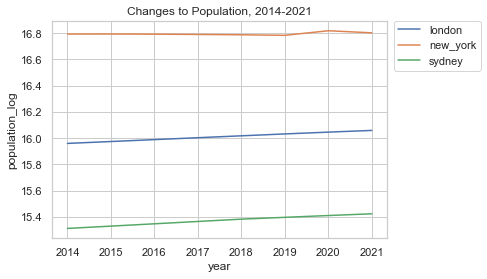

In [246]:
# Visualise change in population of the 3 cities
g=sns.lineplot(x="year", y="population_log", data=city_counts, hue='location')
g.set_title('Changes to Population, 2014-2021')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# London & Sydney display some growth over the period
# New York population broadly unchanged over the period

Cycling Uptake

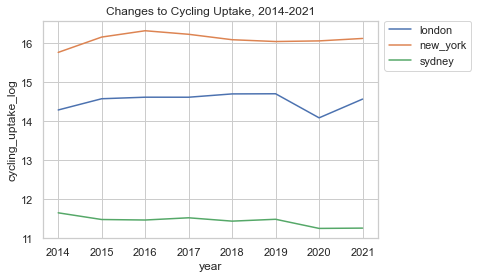

In [247]:
# Visualise change in cycling uptake of the 3 cities
g=sns.lineplot(x="year", y="cycling_uptake_log", data=city_counts, hue='location')
g.set_title('Changes to Cycling Uptake, 2014-2021')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Notes for future: see if the two plots can be combined
# Cycling on one y axis and population on another y axis
# Also see if can set index at 2014 = 100 and then show changes from there
# Check Kevin to prettify

# London
# See observations below on seperate chart for London only on non log scale

# New York
# Very strong rise in early years and then small decline in the interim pre COVID
# Recovery post COVID but no new highs

# Sydney
# Peak uptake was in 2014 and has been in decline since
# Difficult to discern COVID impact as uptake cratered already in 2017
# 2018 data may need to checked to see if there are some counts missing
# Since 2017, annual uptake numbers irrespective 2018 have been declining
# 2021/22 numbers have also cratered
# Need to check this data set

# Combined log scales between population and cycling uptake
# Relative log scale suggests only New York is cycling proportionate to its population
# London slightly less than is proportionate for its relative population
# Sydney is not a cycling city
# Cycling count significantly lower than its proportionate share, given population
# But Sydney cycling data is not full year so need to be cautious

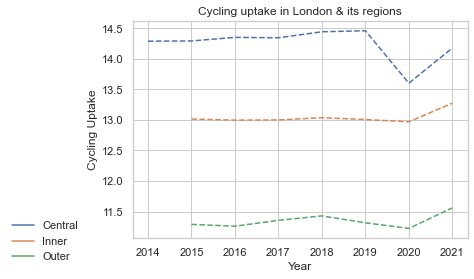

In [248]:
# Visualise change in uptake in the 3 parts of London
g=sns.lineplot(x="year", y="log_total_uptake_ldn", data=df1, hue='functional_cycling_area', 
               linestyle='dashed')
g.set_title('Cycling uptake in London & its regions')
g.set_ylabel('Cycling Uptake')
g.set_xlabel('Year')
plt.legend(bbox_to_anchor=(-0.15, 0.1), borderaxespad=0, frameon=False)


# Outer London uptake peaked in 2018 well before COVID
# Uptake in Outer London continued to drop during pandemic
# It has recovered above pre-pandemic peak

# Inner London uptake has been steady with almost no drop during COVID
# Uptake in Inner London has actually increased strongly post pandemic normalisation in 2020-21

# Central London uptake was increasing steadily until COVID
# Very sharp decline during COVID
# Strong recovery in post pandemic normalisation but has not recovered to pre-pandemic peak
# This has some missing data problems 
# As such the regions arent directly comparable
# This is for demonstration purposes only
# 2019-2020 drop is primarily due to missing data problem
# London wasnt counting cyclists during Covid19

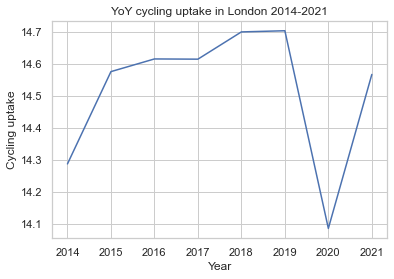

In [249]:
# Visualise the change in all areas of London combined
# Visualising on its own to manage scalar effects more tightly 
# London is city of most interest
# Worth look at it on its own and also versus other cities
# Create the line chart to visualise the change
plt.plot(df['year'], df['log_total_uptake_ldn'])

# Adding the aesthetics
plt.title("YoY cycling uptake in London 2014-2021")
plt.xlabel('Year')
plt.ylabel('Cycling uptake')

# Show the plot
plt.show()

# Strong growth from 2014 onwards every year although slows down dramatically in 219
# Big decline in 2019-2020 due to Covid-19 when lockdowns were in force
# Post pandemic recovery in numbers still below 2015
# Although 2021 numbers are not for full year, they do go up to end of first week of December 2021
# Shows that there is certainly room to increase cycling uptake from current levels
# Although expect that cycling counts should naturally creep up as post Covid normalisation continues

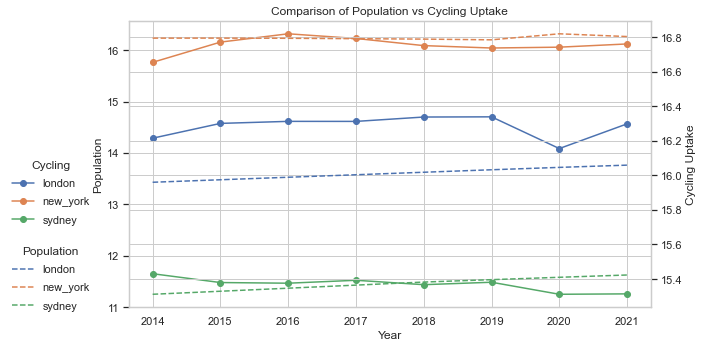

In [250]:
# Visualise if cycling uptake in each city is proportionate to its population
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 5)

# twinx() function is required to have two 'y-axis', for two 'x-axis' we will use twiny() function
ax2 = ax1.twinx()

# Plotting both DFs
city_counts_piv_CU.plot(x='year',y=['london','new_york','sydney'] ,marker='o', ax=ax1)
city_counts_piv_pop.plot(x='year',y=['london','new_york','sydney'], linestyle='dashed', ax=ax2)
# Plotting attributes
ax1.set_title('Comparison of Population vs Cycling Uptake')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population')
ax2.set_ylabel('Cycling Uptake')
ax1.legend(title='Cycling' ,loc='center', bbox_to_anchor=(-0.15,0.4), labelspacing = 0.75, 
           frameon=False)
ax2.legend(title='Population', loc='center', bbox_to_anchor=(-0.15,0.1), labelspacing = 0.75, 
           frameon=False)

plt.tight_layout()
plt.show()

# MAy be better to index the data from 2015 and display for Final presentationt


## Quantitative Analysis

Although the data set is relatively small with just over 195 rows of data, it is worth running some simple quantitative analysis to investigate if traffic flow and car ownership have any influence on each other and more importantly on cycling uptake.

### Preparing the data for Quantitative Analysis

In [251]:
# Getting the shape of traffic flow, Car ownership and cycle count organised 
# Melt the dataframe on car ownership
# This will align shape for further analysis
# will categorise the boroughs into central, inner and outer london values
df6 = pd.melt(car_own, id_vars =['year'], value_vars =['city_of_london', 'barking_and_dagenham', 'barnet', 'bexley', 
                                                      'brent', 'bromley', 'camden', 'croydon', 'ealing', 'enfield', 
                                                      'greenwich', 'hackney', 'hammersmith_and_fulham', 'haringey', 
                                                      'harrow', 'havering', 'hillingdon', 'hounslow', 'islington', 
                                                      'kensington_and_chelsea', 'kingston_upon_thames', 'lambeth', 
                                                      'lewisham', 'merton', 'newham', 'redbridge', 'richmond_upon_thames', 
                                                      'southwark', 'sutton', 'tower_hamlets', 'waltham_forest', 
                                                      'wandsworth', 'westminster'])

In [252]:
# Rename variable to align to other datasets on london
df6 = df6.rename(columns={'variable': 'borough', 'value': 'car_ownership_count'})

In [253]:
# Melt the dataframe on traffic flows
# This will align shape for further analysis
# Will categorise the boroughs into central, inner and outer london values

df7 = pd.melt(traffic_flow, id_vars =['year'], value_vars =['city_of_london', 'barking_and_dagenham', 'barnet', 'bexley', 
                                                      'brent', 'bromley', 'camden', 'croydon', 'ealing', 'enfield', 
                                                      'greenwich', 'hackney', 'hammersmith_and_fulham', 'haringey', 
                                                      'harrow', 'havering', 'hillingdon', 'hounslow', 'islington', 
                                                      'kensington_and_chelsea', 'kingston_upon_thames', 'lambeth', 
                                                      'lewisham', 'merton', 'newham', 'redbridge', 'richmond_upon_thames', 
                                                      'southwark', 'sutton', 'tower_hamlets', 'waltham_forest', 
                                                      'wandsworth', 'westminster'])

In [254]:
# Rename variable to align to other datasets on london
df7 = df7.rename(columns={'variable': 'borough', 'value': 'traffic_flow'})

In [255]:
# Merge the traffic flow and car ownership details
dfs = [df6, df7]
cols= ["year", "borough"]
other_stats = ft.reduce(lambda left, right: pd.merge(left, right, on=cols), dfs)

In [256]:
# Now manipulate cycle count data in london and add to above dataframe
# reshape london df into a smaller df8 so its more resource efficient during manipulation
df8 = london_complete.drop(['latitude', 'longitude', 'survey_date', 'number_of_male_cycles', 
                            'number_of_female_cycles', 'number_of_unknown_cycles', 'day_of_week', 
                           'month', 'number_of_private_cycles', 'season', 'number_of_private_cycles', 
                           'number_of_cycle_hire_bikes', 'total_outer', 'total_inn_cen', 'weather', 'period'], axis=1)

In [257]:
# Align name of boroughs across df8 so that it can be merged 
# Change content of borough column into lower case 
df8['borough'] = df8['borough'].str.lower()
# Replace & with and
df8.replace({'borough': '&'}, {'borough': 'and'}, regex=True, inplace = True)
# Strip spaces with _
df8.replace({'borough': ' '}, {'borough': '_'}, regex=True, inplace = True)

In [258]:
# Sort by year and borough to align to traffic and car ownership count data
df8 = df8.groupby(['year', 'borough'], as_index=False)['total_uptake'].sum()
df8.sort_values(['borough'], inplace = True)

In [259]:
# Merge the traffic flow and car ownership details
dfs = [other_stats, df8]
cols= ["year", "borough"]
combined_stats_ldn = ft.reduce(lambda left, right: pd.merge(left, right, on=cols), dfs)

In [260]:
# Strip non quantitative data columns
# Will use these to test for correlation amongst numeric variable
df10=combined_stats_ldn.drop(['year', 'borough'], axis=1)

In [261]:
# Rename variable for clarity on visual analysis
df10 = df10.rename(columns={'car_ownership_count': 'car ownership', 'traffic_flow': 'traffic flow',
                           'total_uptake': 'cycling uptake'})

### Conducting the analysis

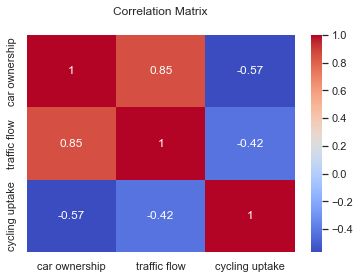

In [262]:
# Correlation of each variable
# Setting up the correlation matrix
plt.figure
sns.heatmap(df10.corr(),annot=True,cmap='coolwarm')
plt.title("Correlation Matrix", pad=20)
plt.show()

# Total traffic flow and car ownership in any location are strongly positively correlated
# Implies an increase in one will lead to an increase in the other 

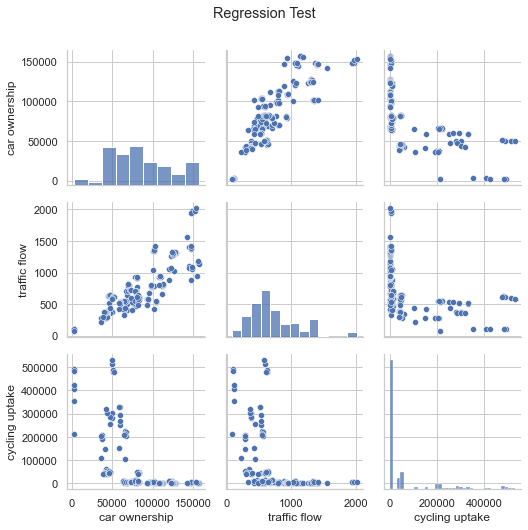

In [263]:
# Visualise sort of relationships if any between the numeric variablessns.set(style="ticks", color_codes=True)
sns.pairplot(df10)

# Setting up adjustments to the plot area
plt.suptitle("Regression Test")
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Can visualise a reasonable linear relationship between traffic flow and car ownership
# Visualisation doesnt suggest linear relationship between cycling up take and other variables
# So although correlation matrix suggest very strong correlation between all three variables
# Limited linear relationship established
# Given the strength of the inverse correlation between cycling uptake and car ownership and traffic flow
# Even though the relationship is not linear, car ownership and thus traffic flow should be targetted for reduction
# This will improve cycling uptake

### Regression Analysis

Will help quantify visualisations in the pairplots above

Car Ownership & Traffic Flow

In [264]:
# Set up a Simple Linear Regression Model
# Dependent Variable.
y = df10['traffic flow']

# Independent Variable.
x = df10['car ownership']

# OLS model.
f = 'y ~ x'
test = ols(f, data=df10).fit()
print(test.summary())

# Pretty strong R2 suggesting 72% of changes in traffic flow are caused by changes in car ownership 
# Prob F-stat is much smaller than the threshold which testifies that the variables are significant
# Large value F Statistic also suggests that the null hypothesis can be rejected
# p-value supports this
# Meaning we can hypothesise statistically that traffic flow and car ownership affect each other

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     503.5
Date:                Sat, 15 Oct 2022   Prob (F-statistic):           4.79e-56
Time:                        16:41:44   Log-Likelihood:                -1333.3
No. Observations:                 198   AIC:                             2671.
Df Residuals:                     196   BIC:                             2677.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.1763     36.119     -0.365      0.7

Car Ownership & Cycling uptake

In [265]:
# Set up a simple linear regression model
# Dependent Variable.
y = df10['cycling uptake']

# Independent Variable.
x = df10['car ownership']

# OLS model.
f = 'y ~ x'
test = ols(f, data=df10).fit()
print(test.summary())

# Much lower R2 which was to be expected 
# Non linear relationship between the variables was previously visualised
# However F Statistic supports that a relationship exists between the variables.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     92.77
Date:                Sat, 15 Oct 2022   Prob (F-statistic):           3.20e-18
Time:                        16:41:45   Log-Likelihood:                -2561.1
No. Observations:                 198   AIC:                             5126.
Df Residuals:                     196   BIC:                             5133.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.215e+05   1.78e+04     12.431      0.0

Traffic Flow & Cycling uptake

In [266]:
# Set up a simple linear regression model
# Dependent Variable.
y = df10['cycling uptake']

# Independent Variable.
x = df10['traffic flow']

# OLS model.
f = 'y ~ x'
test = ols(f, data=df10).fit()
print(test.summary())

# Even lower R - squared but again output is expected
# A non linear relationship between the variables was previously visualised
# Not real world useful
# F Statistic still significant enough to suggest a relationship between variables


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     42.09
Date:                Sat, 15 Oct 2022   Prob (F-statistic):           6.95e-10
Time:                        16:41:47   Log-Likelihood:                -2580.3
No. Observations:                 198   AIC:                             5165.
Df Residuals:                     196   BIC:                             5171.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.615e+05   1.69e+04      9.542      0.0

Considering all the factors impacting cycling uptake the most

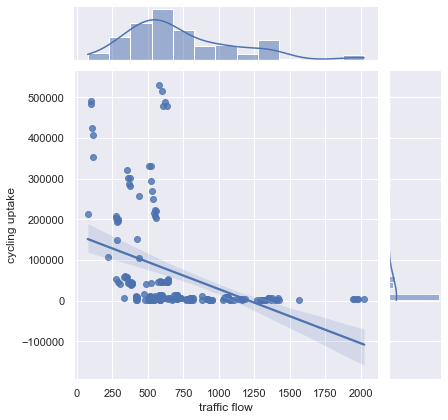

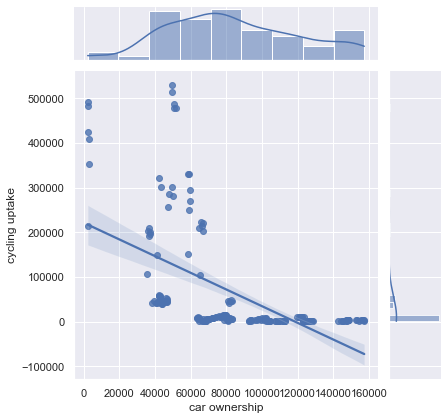

In [267]:
# Visualise the MLR using a jointplot
# Main chart shows how the two variables x & y behave with respect to each other
# Chart at the top shows distribution of independent variable
# Chart at the right hand side shows distribution of y variable

sns.set(style="darkgrid")
sns.jointplot(x='traffic flow',y='cycling uptake',data=df10, kind="reg")
sns.jointplot(x='car ownership',y='cycling uptake',data=df10, kind="reg")
plt.show()

# Confirms that neither distributions are normal
# Main charts confirm that the relationship between the variables are not linear
# This can be viewed as a zoomed summary of the information previously presented in the pairplots